In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii
from SED_v8 import AGN
from match import match
from mag_flux import mag_to_flux
from mag_flux import magerr_to_fluxerr
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const


path='/Users/connor_auge/Research/Disertation/catalogs/'


z_min = 0.0
z_max = 1.2

Lx_min = 43
Lx_max = 60

COSMOS_filters = np.array(['Fx_hard', 'Fx_soft', 'nan', 'FLUX_GALEX_FUV', 'FLUX_GALEX_NUV', 'U', 'G', 'R', 'I', 'Z', 'yHSC_FLUX_APER2', 'J_FLUX_APER2', 'H_FLUX_APER2',
                          'Ks_FLUX_APER2', 'SPLASH_1_FLUX', 'SPLASH_2_FLUX', 'SPLASH_3_FLUX', 'SPLASH_4_FLUX', 'FLUX_24', 'FLUX_100', 'FLUX_160', 'FLUX_250', 'FLUX_350', 'FLUX_500'])

# COSMOS_filters = np.array(['Fx_hard', 'Fx_soft', 'nan', 'FLUX_GALEX_FUV', 'FLUX_GALEX_NUV', 'U', 'G', 'R', 'I', 'Z', 'yHSC_FLUX_APER2', 'J_FLUX_APER2', 'H_FLUX_APER2',
#                           'Ks_FLUX_APER2', 'SPLASH_1_FLUX', 'SPLASH_2_FLUX', 'SPLASH_3_FLUX', 'SPLASH_4_FLUX', 'FLUX_24', 'FLUX_100', 'FLUX_160', 'FLUX_250', 'FLUX_350', 'FLUX_500',
#                            'SCUBA2', 'VLA2'])
# Filters used in the S82X field
S82X_filters = np.asarray(['Fx_hard', 'Fx_soft', 'nan', 'MAG_FUV', 'MAG_NUV', 'U', 'G', 'R', 'I', 'Z',
                          'JVHS', 'HVHS', 'KVHS', 'W1', 'W2', 'W3', 'W4', 'nan', 'FLUX_250_s82x', 'FLUX_350_s82x', 'FLUX_500_s82x'])

# Filters used in the GOODS-N/S field
GOODSS_auge_filters = np.asarray(['Fx_hard', 'Fx_soft', 'nan', 'FLUX_GALEX_FUV', 'FLUX_GALEX_NUV', 'U', 'F435W', 'B_FLUX_APER2', 'V_FLUX_APER2', 'F606W', 'R', 'I',
                                  'F775W', 'F814W', 'Z', 'F850LP', 'F098M', 'F105W', 'F125W', 'JVHS', 'F140W', 'F160W', 'HVHS', 'KVHS', 'SPLASH_1_FLUX', 'SPLASH_2_FLUX', 'SPLASH_3_FLUX', 'SPLASH_4_FLUX', 'FLUX_24', 'MIPS2', 'FLUX_100_goodsS', 'FLUX_160_goodsS', 'FLUX_250_goodsS', 'FLUX_350_goodsS', 'FLUX_500_goodsS'])

GOODSN_auge_filters = np.asarray(['Fx_hard', 'Fx_soft', 'nan', 'FLUX_GALEX_FUV', 'FLUX_GALEX_NUV', 'U', 'F435W', 'B_FLUX_APER2', 'V_FLUX_APER2', 'F606W', 'R', 'I', 'F775W', 'F814W', 'Z', 'F105W', 'F125W', 'JVHS', 'F140W', 'F160W', 'HVHS', 'KVHS',
                                  'SPLASH_1_FLUX', 'SPLASH_2_FLUX', 'SPLASH_3_FLUX', 'SPLASH_4_FLUX', 'FLUX_24', 'MIPS2', 'FLUX_100_goodsN', 'FLUX_160_goodsN', 'FLUX_250_goodsN', 'FLUX_350_goodsN', 'FLUX_500_goodsN'])


check_sed_out = []
check_sed_out10 = []
F24_out, F24err_out = [],[]
F250_out, F250err_out = [],[]
F350_out, F350err_out = [],[]
F500_out, F500err_out = [],[]
ID_out, field_out = [],[]
spec_z_out, Lx_out = [],[]
ra_out,dec_out = [],[]
F4_out = []

In [2]:
# Read in the COSMOS data
with fits.open(path+'cosmos2020/classic/COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul:
    cosmos_data = hdul[1].data
    
with fits.open(path+'chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul:
    chandra_cosmos_data = hdul[1].data
    
with fits.open(path+'chandra_cosmos_legacy_spectra_bestfit_20210225.fits') as hdul:
    chandra_cosmos2_data = hdul[1].data
    
with fits.open(path+'chandra_cosmos_legacy_spectra_bestfit_ComptonThick_Lanzuisi18.fits') as hdul:
    chandra_cosmos_ct_data = hdul[1].data
    
deimos = ascii.read('/Users/connor_auge/Downloads/deimos_10k_March2018_new/deimos_redshifts.tbl')

In [3]:
# COSMOS data matching
deimos_id = np.asarray(deimos['ID'])
deimos_z = np.asarray(deimos['zspec'])
deimos_remarks = np.asarray(deimos['Remarks'])
deimos_ID = np.asarray([int(i[1:]) for i in deimos_id if 'L' in i])
deimos_z_spec = np.asarray([deimos_z[i] for i in range(len(deimos_z)) if 'L' in deimos_id[i]])

# Gather all IDs
chandra_cosmos_phot_id = chandra_cosmos_data['id_k_uv']
cosmos_laigle_id = cosmos_data['ID_COSMOS2015']
cosmos_xid = cosmos_data['id_chandra']
chandra_cosmos_xid = chandra_cosmos_data['id_x']
chandra_cosmos2_xid = chandra_cosmos2_data['id_x']
chandra_cosmos_ct_xid = chandra_cosmos_ct_data['id_x']

# X-ray coords
chandra_cosmos_RA = chandra_cosmos_data['RA_x']
chandra_cosmos_DEC = chandra_cosmos_data['DEC_x']

# Redshfits
cosmos_sz = cosmos_data['sz_zspec']
cosmos_ez = cosmos_data['ez_z_spec']
chandra_cosmos_z = chandra_cosmos_data['z_spec']
chandra_cosmos_z_phot = chandra_cosmos_data['z_best']

chandra_cosmos2_z = chandra_cosmos2_data['z_best']

# X-ray Flux
chandra_cosmos_Fx_hard = chandra_cosmos_data['flux_h']
chandra_cosmos_Fx_soft = chandra_cosmos_data['flux_s']
chandra_cosmos_Fx_full = chandra_cosmos_data['flux_f']

chandra_cosmos2_Fx_hard = chandra_cosmos2_data['flux_210']
chandra_cosmos2_Fx_soft = chandra_cosmos2_data['flux_052']
chandra_cosmos2_Fx_full = chandra_cosmos2_data['flux_0510']

# X-ray Luminosity (non-log)
chandra_cosmos_Lx_hard = np.asarray([10**i for i in chandra_cosmos_data['Lx_210']])
chandra_cosmos_Lx_soft = np.asarray([10**i for i in chandra_cosmos_data['Lx_052']])
chandra_cosmos_Lx_full = np.asarray([10**i for i in chandra_cosmos_data['Lx_0510']])

chandra_cosmos2_Lx_hard = np.asarray([10**i for i in chandra_cosmos2_data['Lx_210']])
chandra_cosmos2_Lx_full = np.asarray([(10**i)*1.64 for i in chandra_cosmos2_data['Lx_210']]) # Correction from hard to full band

# Other Chandra Data
# Spec-type from hardness ratio
chandra_cosmos_spec_type = chandra_cosmos_data['spec_type'] # spec type

# Column Density
chandra_cosmos_nh = chandra_cosmos_data['Nh']
chandra_cosmos_nh_lo = chandra_cosmos_data['Nh_lo']
chandra_cosmos_nh_hi = chandra_cosmos_data['Nh_up']

chandra_cosmos2_nh = chandra_cosmos2_data['nh']
chandra_cosmos2_nh_lo_err = chandra_cosmos2_data['nh_lo_err']
chandra_cosmos2_nh_up_err = chandra_cosmos2_data['nh_up_err']


# Absorption Correction - full, hard, and soft bands with uppr and lower limts
chandra_cosmos_abs_corr_h = chandra_cosmos_data['abs_corr_210'] 
chandra_cosmos_abs_corr_up_h = chandra_cosmos_data['abs_corr_210_up']
chandra_cosmos_abs_corr_lo_h = chandra_cosmos_data['abs_corr_210_lo']
chandra_cosmos_abs_corr_s = chandra_cosmos_data['abs_corr_052']
chandra_cosmos_abs_corr_up_s = chandra_cosmos_data['abs_corr_052_up']
chandra_cosmos_abs_corr_lo_s = chandra_cosmos_data['abs_corr_052_lo']
chandra_cosmos_abs_corr_f = chandra_cosmos_data['abs_corr_0510']
chandra_cosmos_abs_corr_up_f = chandra_cosmos_data['abs_corr_0510_up']
chandra_cosmos_abs_corr_lo_f = chandra_cosmos_data['abs_corr_0510_lo']


# X-ray luminosities and Column densites from the Chandra Compoton thick catalog
chandra_cosmos_ct_Lx_hard_obs = np.asarray([10**i for i in chandra_cosmos_ct_data['loglx']])
chandra_cosmos_ct_Lx_full_obs = np.asarray([(10**i)*1.64 for i in chandra_cosmos_ct_data['loglx']])
chandra_cosmos_ct_Lx_hard = np.asarray([10**i for i in chandra_cosmos_ct_data['loglxcor']])
chandra_cosmos_ct_Lx_full = np.asarray([(10**i)*1.64 for i in chandra_cosmos_ct_data['loglxcor']])
chandra_cosmos_ct_nh = chandra_cosmos_ct_data['nh2_22']

# Gather DEIMOS spec redshifts to redshift array
for i in range(len(chandra_cosmos_z)):
    ind = np.where(deimos_ID == chandra_cosmos_phot_id[i])[0]
    if len(ind) > 0:
        if deimos_z_spec[ind][0] > 0:
            chandra_cosmos_z[i] = deimos_z_spec[ind][0]
        else:
            continue
    else:
        continue

# Gather Luminosity absorption corrections from the Chandra COSMOS cat1 and correct the luminositeis
abs_corr_use_h = []
abs_corr_use_s = []
abs_corr_use_f = []
check_abs = []
for i in range(len(chandra_cosmos_abs_corr_f)):
    if chandra_cosmos_abs_corr_f[i] != -99.0:
        abs_corr_use_f.append(chandra_cosmos_abs_corr_f[i])
        abs_corr_use_h.append(chandra_cosmos_abs_corr_h[i])
        abs_corr_use_s.append(chandra_cosmos_abs_corr_s[i])
        check_abs.append(0)

    elif chandra_cosmos_abs_corr_up_f[i] != -99.0:
        abs_corr_use_f.append(chandra_cosmos_abs_corr_up_f[i])
        abs_corr_use_h.append(chandra_cosmos_abs_corr_up_h[i])
        abs_corr_use_s.append(chandra_cosmos_abs_corr_up_s[i])
        check_abs.append(1)

    elif chandra_cosmos_abs_corr_lo_f[i] != -99.0:
        abs_corr_use_f.append(chandra_cosmos_abs_corr_lo_f[i])
        abs_corr_use_h.append(chandra_cosmos_abs_corr_lo_h[i])
        abs_corr_use_s.append(chandra_cosmos_abs_corr_lo_s[i])
        check_abs.append(2)

    else:
        print('NO GOOD ABSORPTION CORRECTION DATA')

check_abs = np.asarray(check_abs)
# Turn final absorption lists into arrays
abs_corr_use_h = np.asarray(abs_corr_use_h)
abs_corr_use_s = np.asarray(abs_corr_use_s)
abs_corr_use_f = np.asarray(abs_corr_use_f)

# Correct the X-ray luminosity from the 2016 Chandra Catalog for absorption
chandra_cosmos_Lx_hard /= abs_corr_use_h
chandra_cosmos_Lx_soft /= abs_corr_use_s
chandra_cosmos_Lx_full /= abs_corr_use_f

# Gather the column density from the three chandra catalogs for the full and hard band Lx
chandra_cosmos_Nh = []
check = []
cosmos_Nh_check = []
for i in range(len(chandra_cosmos_Lx_full)):    
    ind = np.where(chandra_cosmos2_xid == chandra_cosmos_xid[i])[0] # Check if there is a match to updated Chandra catalog 
    ind_ct = np.where(chandra_cosmos_ct_xid == chandra_cosmos_xid[i])[0] # Check if there is a match to compton thick Chandra catalog 

    if len(ind_ct) > 0:
        chandra_cosmos_Nh.append(chandra_cosmos_ct_nh[ind_ct][0]) # if there is a match append Nh from compton thick catalog 
        chandra_cosmos_Lx_hard[i] = chandra_cosmos_ct_Lx_hard[ind_ct] # replace Lx from original Chandra catalog with that from the CT cat
        chandra_cosmos_Lx_full[i] = chandra_cosmos_ct_Lx_full[ind_ct]
        check.append(3) # count which catalog data is from
        cosmos_Nh_check.append(0)
        check_abs[i] = 0

    elif len(ind) > 0:
        chandra_cosmos_Lx_hard[i] = chandra_cosmos2_Lx_hard[ind] # replace Lx from orginal Chandra catalog with that from updated cat
        chandra_cosmos_Lx_full[i] = chandra_cosmos2_Lx_full[ind]
        check_abs[i] = 0
        if chandra_cosmos2_nh_lo_err[ind][0] == -99.:
            chandra_cosmos_Nh.append(chandra_cosmos2_nh[ind][0]+chandra_cosmos2_nh_up_err[ind][0]) # if there is Nh upper limit in updated cat append to Nh list
            # chandra_cosmos_Nh.append(0.0)
            check.append(2.5)
            cosmos_Nh_check.append(1)
        else:
            chandra_cosmos_Nh.append(chandra_cosmos2_nh[ind][0]) # if there is a match append Nh from updated catalog
            check.append(2)
            cosmos_Nh_check.append(0)
    else: # if no matches to updated or CT catalogs take Nh value from original catalog
        if chandra_cosmos_nh[i] == -99.: # If no good value take upper or lower limits 
            if chandra_cosmos_nh_lo[i] != -99.:
                # chandra_cosmos_Nh.append(0.0)
                chandra_cosmos_Nh.append(chandra_cosmos_nh_lo[i])
                cosmos_Nh_check.append(2)
            else:
                # chandra_cosmos_Nh.append(0.0)
                chandra_cosmos_Nh.append(chandra_cosmos_nh_hi[i])
                cosmos_Nh_check.append(1)
        else:    
            chandra_cosmos_Nh.append(chandra_cosmos_nh[i])
            cosmos_Nh_check.append(0)
        check.append(1)
chandra_cosmos_Nh = np.asarray(chandra_cosmos_Nh)*1E22
check = np.asarray(check)
cosmos_Nh_check = np.asarray(cosmos_Nh_check)

print('COSMOS All Lx cat: ', len(chandra_cosmos_Lx_full))


COSMOS All Lx cat:  4016


In [4]:
# Limit chandra sample to sources in z and Lx range
cosmos_condition = (chandra_cosmos_z > z_min) & (chandra_cosmos_z <= z_max) & (np.log10(chandra_cosmos_Lx_full) >= Lx_min) & (np.log10(chandra_cosmos_Lx_full) <= Lx_max) & (chandra_cosmos_phot_id != -99.)

chandra_cosmos_phot_id = chandra_cosmos_phot_id[cosmos_condition]
chandra_cosmos_xid = chandra_cosmos_xid[cosmos_condition]
chandra_cosmos_RA = chandra_cosmos_RA[cosmos_condition]
chandra_cosmos_DEC = chandra_cosmos_DEC[cosmos_condition]
chandra_cosmos_z = chandra_cosmos_z[cosmos_condition]
chandra_cosmos_Fx_full = chandra_cosmos_Fx_full[cosmos_condition]
chandra_cosmos_Fx_hard = chandra_cosmos_Fx_hard[cosmos_condition]
chandra_cosmos_Fx_soft = chandra_cosmos_Fx_soft[cosmos_condition]
chandra_cosmos_Lx_full = chandra_cosmos_Lx_full[cosmos_condition]
chandra_cosmos_Lx_hard = chandra_cosmos_Lx_hard[cosmos_condition]
chandra_cosmos_Lx_soft = chandra_cosmos_Lx_soft[cosmos_condition]
chandra_cosmos_spec_type = chandra_cosmos_spec_type[cosmos_condition]
chandra_cosmos_Nh = chandra_cosmos_Nh[cosmos_condition]
cosmos_Nh_check = cosmos_Nh_check[cosmos_condition]
abs_corr_use_h = abs_corr_use_h[cosmos_condition]
abs_corr_use_s = abs_corr_use_s[cosmos_condition]
abs_corr_use_f = abs_corr_use_f[cosmos_condition]
check_abs = check_abs[cosmos_condition]
print('COSMOS Lx z: ', len(chandra_cosmos_phot_id))

#  Match chandra subsample to photometry catalog
cosmos_ix, cosmos_iy = match(chandra_cosmos_phot_id,cosmos_laigle_id) # match cats based on laigle ID

cosmos_laigle_id_match = cosmos_laigle_id[cosmos_iy]
chandra_cosmos_phot_id_match = chandra_cosmos_phot_id[cosmos_ix]
chandra_cosmos_xid_match = chandra_cosmos_xid[cosmos_ix]
chandra_cosmos_RA_match = chandra_cosmos_RA[cosmos_ix]
chandra_cosmos_DEC_match = chandra_cosmos_DEC[cosmos_ix]
chandra_cosmos_z_match = chandra_cosmos_z[cosmos_ix]
chandra_cosmos_Fx_full_match = chandra_cosmos_Fx_full[cosmos_ix]
chandra_cosmos_Fx_hard_match = chandra_cosmos_Fx_hard[cosmos_ix]
chandra_cosmos_Fx_soft_match = chandra_cosmos_Fx_soft[cosmos_ix]
chandra_cosmos_Lx_full_match = chandra_cosmos_Lx_full[cosmos_ix]
chandra_cosmos_Lx_hard_match = chandra_cosmos_Lx_hard[cosmos_ix]
chandra_cosmos_Lx_soft_match = chandra_cosmos_Lx_soft[cosmos_ix]
chandra_cosmos_spec_type_match = chandra_cosmos_spec_type[cosmos_ix]
chandra_cosmos_Nh_match = chandra_cosmos_Nh[cosmos_ix]
cosmos_Nh_check_match = cosmos_Nh_check[cosmos_ix]
abs_corr_use_h_match = abs_corr_use_h[cosmos_ix]
abs_corr_use_s_match = abs_corr_use_s[cosmos_ix]
abs_corr_use_f_match = abs_corr_use_f[cosmos_ix]
check_abs_match = check_abs[cosmos_ix]
print('COSMOS phot match: ', len(chandra_cosmos_phot_id_match))

COSMOS Lx z:  682
COSMOS phot match:  664


In [5]:
# Convert the X-ray flux values to from cgs to mJy
chandra_cosmos_Fx_full_match_mjy = chandra_cosmos_Fx_full_match*4.136E8/(10-0.5)
chandra_cosmos_Fx_hard_match_mjy = chandra_cosmos_Fx_hard_match*4.136E8/(10-2)
chandra_cosmos_Fx_soft_match_mjy = chandra_cosmos_Fx_soft_match*4.136E8/(2-0.5)

chandra_cosmos_fx_full_match_mjy_int = chandra_cosmos_Fx_full_match_mjy/abs_corr_use_f_match
chandra_cosmos_Fx_hard_match_mjy_int = chandra_cosmos_Fx_hard_match_mjy/abs_corr_use_h_match
chandra_cosmos_Fx_soft_match_mjy_int = chandra_cosmos_Fx_soft_match_mjy/abs_corr_use_s_match

cosmos_Fx_int_array = np.array([chandra_cosmos_Fx_hard_match_mjy, chandra_cosmos_Fx_soft_match_mjy]).T
# Create a 1D array of NaN that is the length of the number of COSMOS sources - used to create "blank" values in flux array
cosmos_nan_array = np.zeros(np.shape(cosmos_laigle_id_match))
cosmos_nan_array[cosmos_nan_array == 0] = np.nan

cosmos_ra = cosmos_data['ALPHA_J2000'][cosmos_iy]
cosmos_dec = cosmos_data['DELTA_J2000'][cosmos_iy]
# Create flux and flux error arrays for the COSMOS data. Matched to chandra data. NaN array separating the X-ray from the FUV data.
cosmos_flux_array = np.array([
    chandra_cosmos_Fx_hard_match_mjy*1000, chandra_cosmos_Fx_soft_match_mjy*1000,
    cosmos_nan_array,
    cosmos_data['GALEX_FUV_FLUX'][cosmos_iy],
    cosmos_data['GALEX_NUV_FLUX'][cosmos_iy],
    cosmos_data['CFHT_u_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_g_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_r_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_i_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_z_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_y_FLUX_APER2'][cosmos_iy],
    cosmos_data['UVISTA_J_FLUX_APER2'][cosmos_iy],
    cosmos_data['UVISTA_H_FLUX_APER2'][cosmos_iy],
    cosmos_data['UVISTA_Ks_FLUX_APER2'][cosmos_iy],
    cosmos_data['SPLASH_CH1_FLUX'][cosmos_iy],
    cosmos_data['SPLASH_CH2_FLUX'][cosmos_iy],
    cosmos_data['SPLASH_CH3_FLUX'][cosmos_iy],
    cosmos_data['SPLASH_CH4_FLUX'][cosmos_iy],
    cosmos_data['FIR_24_FLUX'][cosmos_iy],
    cosmos_data['FIR_100_FLUX'][cosmos_iy],
    cosmos_data['FIR_160_FLUX'][cosmos_iy],
    cosmos_data['FIR_250_FLUX'][cosmos_iy],
    cosmos_data['FIR_350_FLUX'][cosmos_iy],
    cosmos_data['FIR_500_FLUX'][cosmos_iy],
    # cosmos_data['FIR_850_FLUX'][cosmos_iy],
    # cosmos_data['FIR_1100_FLUX'][cosmos_iy],
    # cosmos_data['FIR_20CM_FLUX'][cosmos_iy]
])

cosmos_flux_err_array = np.array([
    chandra_cosmos_Fx_hard_match_mjy*1000*0.2, chandra_cosmos_Fx_soft_match_mjy*1000*0.2,
    cosmos_nan_array,
    cosmos_data['GALEX_FUV_FLUXERR'][cosmos_iy],
    cosmos_data['GALEX_NUV_FLUXERR'][cosmos_iy],
    cosmos_data['CFHT_u_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_g_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_r_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_i_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_z_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_y_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['UVISTA_J_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['UVISTA_H_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['UVISTA_Ks_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['SPLASH_CH1_FLUXERR'][cosmos_iy],
    cosmos_data['SPLASH_CH2_FLUXERR'][cosmos_iy],
    cosmos_data['SPLASH_CH3_FLUXERR'][cosmos_iy],
    cosmos_data['SPLASH_CH4_FLUXERR'][cosmos_iy],
    cosmos_data['FIR_24_FLUXERR'][cosmos_iy],
    cosmos_data['FIR_100_FLUXERR'][cosmos_iy],
    cosmos_data['FIR_160_FLUXERR'][cosmos_iy],
    cosmos_data['FIR_250_FLUXERR'][cosmos_iy],
    cosmos_data['FIR_350_FLUXERR'][cosmos_iy],
    cosmos_data['FIR_500_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_850_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_1100_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_20CM_FLUXERR'][cosmos_iy]
])

# Transpose arrays so each row is a new source and each column is a obs filter
cosmos_flux_array = cosmos_flux_array.T
cosmos_flux_err_array = cosmos_flux_err_array.T


cosmos_24 = cosmos_data['FIR_24_FLUX'][cosmos_iy]
cosmos_24err = cosmos_data['FIR_24_FLUXERR'][cosmos_iy]

cosmos_ch4 = cosmos_data['SPLASH_CH4_FLUX'][cosmos_iy]
cosmos_ch4err = cosmos_data['SPLASH_CH4_FLUXERR'][cosmos_iy]

cosmos_irac2 = cosmos_data['SPLASH_CH2_FLUX'][cosmos_iy]
cosmos_100 = cosmos_data['FIR_100_FLUX'][cosmos_iy]
cosmos_160 = cosmos_data['FIR_160_FLUX'][cosmos_iy]
cosmos_250 = cosmos_data['FIR_250_FLUX'][cosmos_iy]
cosmos_350 = cosmos_data['FIR_350_FLUX'][cosmos_iy]
cosmos_500 = cosmos_data['FIR_500_FLUX'][cosmos_iy]

cosmos_100err = cosmos_data['FIR_100_FLUXERR'][cosmos_iy]
cosmos_160err = cosmos_data['FIR_160_FLUXERR'][cosmos_iy]
cosmos_250err = cosmos_data['FIR_250_FLUXERR'][cosmos_iy]
cosmos_350err = cosmos_data['FIR_350_FLUXERR'][cosmos_iy]
cosmos_500err = cosmos_data['FIR_500_FLUXERR'][cosmos_iy]

check_sed = []
for i in range(len(chandra_cosmos_phot_id_match)):
    source = AGN(chandra_cosmos_phot_id_match[i], chandra_cosmos_z_match[i], COSMOS_filters, cosmos_flux_array[i], cosmos_flux_err_array[i])
    source.MakeSED(data_replace_filt=['FLUX_24'])
    source.FIR_extrap(['FLUX_24', 'FLUX_100', 'FLUX_160', 'FLUX_250', 'FLUX_350', 'FLUX_500'])
    shape = source.SED_shape()
    check = source.check_SED10(10, check_span=2.75)
    check6 = source.check_SED(6, check_span=2.75)
    check_sed.append(check6)
    check_sed_out.append(check6)
    check_sed_out10.append(check)
    ID_out.append(chandra_cosmos_phot_id_match[i])
    spec_z_out.append(chandra_cosmos_z_match[i])
    ra_out.append(cosmos_ra[i])
    dec_out.append(cosmos_dec[i])
    Lx_out.append(chandra_cosmos_Lx_full_match[i])
    F4_out.append(cosmos_irac2[i])
    F24_out.append(cosmos_24[i])
    F24err_out.append(cosmos_24err[i])
    F250_out.append(cosmos_250[i])
    F250err_out.append(cosmos_250err[i])
    F350_out.append(cosmos_350[i])
    F350err_out.append(cosmos_350err[i])
    F500_out.append(cosmos_500[i])
    F500err_out.append(cosmos_500err[i])
    field_out.append('COSMOS')

check_sed = np.asarray(check_sed)

In [6]:
print(len(cosmos_24),len(cosmos_24[cosmos_24 > 0]),len(cosmos_24[cosmos_24 < 0]),len(cosmos_24[cosmos_24 == 0]))
print(len(cosmos_24err),len(cosmos_24err[cosmos_24err > 0]),len(cosmos_24err[cosmos_24err < 0]))

664 597 65 2
664 599 65


In [7]:
good_cosmos_sed = (cosmos_24 > 0) & (cosmos_24err/cosmos_24 < 0.5)

good_cosmos_sed = check_sed == 'GOOD'

good_cosmos_24 = cosmos_24[good_cosmos_sed]
good_cosmos_24err = cosmos_24err[good_cosmos_sed]

good_cosmos_100 = cosmos_100[good_cosmos_sed]
good_cosmos_160 = cosmos_160[good_cosmos_sed]
good_cosmos_250 = cosmos_250[good_cosmos_sed]
good_cosmos_350 = cosmos_350[good_cosmos_sed]
good_cosmos_500 = cosmos_500[good_cosmos_sed]

good_cosmos_100err = cosmos_100err[good_cosmos_sed]
good_cosmos_160err = cosmos_160err[good_cosmos_sed]
good_cosmos_250err = cosmos_250err[good_cosmos_sed]
good_cosmos_350err = cosmos_350err[good_cosmos_sed]
good_cosmos_500err = cosmos_500err[good_cosmos_sed]


/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/1626388061.py:1: RuntimeWarning: divide by zero encountered in true_divide
  good_cosmos_sed = (cosmos_24 > 0) & (cosmos_24err/cosmos_24 < 0.5)


In [8]:
frac_err_lim = 0.5

good_100_check = (good_cosmos_100 > 0) & (good_cosmos_100err/good_cosmos_100 < frac_err_lim)
good_160_check = (good_cosmos_160 > 0) & (good_cosmos_160err/good_cosmos_160 < frac_err_lim)

good_250_check = (good_cosmos_250 > 0) & (good_cosmos_250err/good_cosmos_250 < frac_err_lim)
good_350_check = (good_cosmos_350 > 0) & (good_cosmos_350err/good_cosmos_350 < frac_err_lim)
good_500_check = (good_cosmos_500 > 0) & (good_cosmos_500err/good_cosmos_500 < frac_err_lim)

/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/926438084.py:6: RuntimeWarning: divide by zero encountered in true_divide
  good_250_check = (good_cosmos_250 > 0) & (good_cosmos_250err/good_cosmos_250 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/926438084.py:7: RuntimeWarning: divide by zero encountered in true_divide
  good_350_check = (good_cosmos_350 > 0) & (good_cosmos_350err/good_cosmos_350 < frac_err_lim)


In [9]:
all_fir_data = good_250_check*good_350_check*good_500_check*good_100_check*good_160_check
all_spire_data = good_250_check*good_350_check*good_500_check

In [10]:
print('Number of sources: ',len(good_cosmos_250))
print('Number of detections in 100: ', np.sum(good_100_check))
print('Number of detections in 160: ', np.sum(good_160_check))
print('Number of detections in 250: ', np.sum(good_250_check))
print('Number of detections in 350: ', np.sum(good_350_check))
print('Number of detections in 500: ', np.sum(good_500_check))
print('Number of detections in all Herschel: ',len(good_cosmos_250[all_fir_data]))
print('Number of detections in all SPIRE: ',len(good_cosmos_250[all_spire_data]))

Number of sources:  624
Number of detections in 100:  215
Number of detections in 160:  155
Number of detections in 250:  172
Number of detections in 350:  99
Number of detections in 500:  34
Number of detections in all Herschel:  20
Number of detections in all SPIRE:  31


In [11]:
any_spire = np.logical_or(good_250_check,np.logical_or(good_350_check,good_500_check))
any_pacs = np.logical_or(good_100_check,good_160_check)
any_fir = np.logical_or(np.logical_or(good_250_check,np.logical_or(good_100_check,good_160_check)),np.logical_or(good_350_check,good_500_check))

print('Detection in any SPIRE band: ',np.sum(any_spire))
print('Detection in any PACS band: ',np.sum(any_pacs))
print('Detection in any Herschel band: ',np.sum(any_fir))

Detection in any SPIRE band:  185
Detection in any PACS band:  248
Detection in any Herschel band:  294


In [12]:
for i in range(len(good_250_check)):
    print(good_250_check[i],good_350_check[i],good_500_check[i])

False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
False False False
True True False
False False False
False False False
False False False
True True True
False False False
False False False
True False False
False False False
True True True
False False False
False False False
False False False
False False False
False False False
True False False
False False False
False False False
False False False
False False False
True True True
False False False
True True True
False False False
False False False
False False False
False False False
False False False
False False False
False False False
True False False
False False False
False Fal

# Check S82X data

In [13]:
# Most recent LaMassa catalog - Includes Photometry and X-ray data
lamassa = fits.open(path+'S82X_catalog_with_photozs_unique_Xraysrcs_likely_cps_w_mbh.fits')
lamassa_data = lamassa[1].data
lamassa_cols = lamassa[1].columns
lamassa.close()

# Updated X-ray catalog from Peca et al.
peca = fits.open(path+'Peca_S82X.fits')
peca_data = peca[1].data
peca.close()

with fits.open(path+'Peca_S82X_full.fit') as hdul:
    peca2_data = hdul[1].data

# WISE catalog with forced photometry on SLOAN sources
unwise = ascii.read('/Users/connor_auge/Desktop/desktop_catalogs/unwise_matches.csv')
unwise_ID = np.asarray(unwise['ID'])
unwise_W1 = np.asarray(unwise['unW1'])
unwise_W2 = np.asarray(unwise['unW2'])
unwise_W3 = np.asarray(unwise['unW3'])
unwise_W4 = np.asarray(unwise['unW4'])
unwise_W1_err = np.asarray(unwise['unW1_err'])
unwise_W2_err = np.asarray(unwise['unW2_err'])
unwise_W3_err = np.asarray(unwise['unW3_err'])
unwise_W4_err = np.asarray(unwise['unW4_err'])

# Gather IDs and sort into usable ID array for LaMassa
lamassa_id = lamassa_data['msid']
lamassa_id_recno = lamassa_data['rec_no']
lamassa_obsID = lamassa_data['OBSID']

s82x_id = []
for i,j in enumerate(lamassa_id):
    if j == 0:
        s82x_id.append(lamassa_id_recno[i])
    else:
        s82x_id.append(j)
s82x_id = np.asarray(s82x_id)

# Additional data from LaMassa
s82x_ra = lamassa_data['XRAY_RA']
s82x_dec = lamassa_data['XRAY_DEC']
s82x_ra_cp = lamassa_data['CP_RA']
s82x_dec_cp = lamassa_data['CP_DEC']
s82x_cat = lamassa_data['XRAY_SRC']
s82x_z = lamassa_data['SPEC_Z']
s82x_phot_z = lamassa_data['PHOTO_Z']
s82x_Lx_full = np.asarray([10**i for i in lamassa_data['FULL_LUM']])
s82x_Lx_hard = np.array([10**i for i in lamassa_data['HARD_LUM']])
s82x_Lx_soft = np.array([10**i for i in lamassa_data['SOFT_LUM']])
s82x_Fx_full = lamassa_data['FULL_FLUX']
s82x_Fx_hard = lamassa_data['HARD_FLUX']
s82x_Fx_soft = lamassa_data['SOFT_FLUX']
s82x_Fx_full_int = s82x_Fx_full.copy()
s82x_Fx_hard_int = s82x_Fx_hard.copy()
s82x_Fx_soft_int = s82x_Fx_soft.copy()

# S82X Spec type data
s82x_spec_type_in = lamassa_data['spec_class']
s82x_spec_class = np.ones(np.shape(s82x_spec_type_in))
for i in range(len(s82x_spec_type_in)):
    if i != 'QSO':
        s82x_spec_class[i] = 2
    else:
        continue

# Read in WISE data 
s82x_W1 = lamassa_data['W1']
s82x_W2 = lamassa_data['W2']
s82x_W3 = lamassa_data['W3']
s82x_W4 = lamassa_data['W4']
s82x_W1_err = lamassa_data['W1_err']
s82x_W2_err = lamassa_data['W2_err']
s82x_W3_err = lamassa_data['W3_err']
s82x_W4_err = lamassa_data['W4_err']

#Replace W3 and W4 data with good data from the unWISE catalog
for i, j in enumerate(s82x_id):
    ind = np.where(unwise_ID == j)[0]
    if len(ind) == 1:
        if np.isnan(unwise_W3[ind]):
            continue
        elif unwise_W3[ind] <= 0.0:
            continue
        elif magerr_to_fluxerr(unwise_W3[ind], unwise_W3_err[ind],'W3',AB=True)/mag_to_flux(unwise_W3[ind],'W3',AB=True) > 0.4:
            continue
        else:
            s82x_W3[i] = unwise_W3[ind][0]
            s82x_W3_err[i] = unwise_W3_err[ind][0]
        if np.isnan(unwise_W4[ind]):
            continue
        elif unwise_W4[ind] <= 0.0:
            continue
        elif magerr_to_fluxerr(unwise_W4[ind], unwise_W4_err[ind], 'W4', AB=True)/mag_to_flux(unwise_W4[ind], 'W4', AB=True) > 0.4:
            continue
        else:
            s82x_W4[i] = unwise_W4[ind][0]
            s82x_W4_err[i] = unwise_W4_err[ind][0]

# New Peca
peca_ID = peca2_data['source']
peca_Lx_full = peca2_data['LintF']
peca_Lx_hard = peca2_data['LintH']
peca_Lx_soft = peca2_data['LintS']
peca_Lx_full_obs = peca2_data['LobsF']
peca_Lx_hard_obs = peca2_data['LobsH']
peca_Lx_soft_obs = peca2_data['LobsS']
peca_Fx_full = peca2_data['FluxF']
peca_Fx_hard = peca2_data['FluxH']
peca_Fx_soft = peca2_data['FluxS']
peca_Nh = peca2_data['NH']
peca_abs_corr_full = peca_Lx_full_obs/peca_Lx_full
peca_abs_corr_hard = peca_Lx_hard_obs/peca_Lx_hard
peca_abs_corr_soft = peca_Lx_soft_obs/peca_Lx_soft

peca_Fx_full_int = peca_Fx_full/peca_abs_corr_full
peca_Fx_hard_int = peca_Fx_hard/peca_abs_corr_hard
peca_Fx_soft_int = peca_Fx_soft/peca_abs_corr_soft


# Fill in Nh data from Peca and replace LaMassa X-ray data with Peca 
s82x_Nh = []
s82x_Nh_check = []
for i, j in enumerate(s82x_id):
    ind = np.where(peca_ID == j)[0]
    if len(ind) == 1:
        s82x_Lx_full[i] = peca_Lx_full[ind][0]
        s82x_Lx_hard[i] = peca_Lx_hard[ind][0]
        s82x_Lx_soft[i] = peca_Lx_soft[ind][0]
        s82x_Fx_full[i] = peca_Fx_full[ind][0]
        s82x_Fx_hard[i] = peca_Fx_hard[ind][0]
        s82x_Fx_soft[i] = peca_Fx_soft[ind][0]
        s82x_Fx_full_int[i] = peca_Fx_full_int[ind][0]
        s82x_Fx_hard_int[i] = peca_Fx_hard_int[ind][0]
        s82x_Fx_soft_int[i] = peca_Fx_soft_int[ind][0]
        
        s82x_Nh.append(peca_Nh[ind][0])
        s82x_Nh_check.append(0)
    else:
        s82x_Nh.append(0.0)
        s82x_Nh_check.append(3)
s82x_Nh = np.asarray(s82x_Nh)
s82x_Nh_check = np.asarray(s82x_Nh_check)

print('S82X All: ', len(s82x_id))



# Limit Stripe82X sample to sources in z and Lx range
s82x_condition = (s82x_z > z_min) & (s82x_z <= z_max) & (np.log10(s82x_Lx_full) >= Lx_min) & (np.log10(s82x_Lx_full) <= Lx_max) & (np.logical_and(s82x_ra >= 13, s82x_ra <=37))
# s82x_condition = (s82x_phot_z > z_min) & (s82x_phot_z <= z_max) & (np.log10(s82x_Lx_full) >= Lx_min) & (np.log10(s82x_Lx_full) <= Lx_max) 

s82x_id = s82x_id[s82x_condition]
s82x_cat = s82x_cat[s82x_condition]
s82x_z = s82x_z[s82x_condition]
s82x_phot_z = s82x_phot_z[s82x_condition]
s82x_ra = s82x_ra[s82x_condition]
s82x_dec = s82x_dec[s82x_condition]
s82x_ra_cp = s82x_ra_cp[s82x_condition]
s82x_dec_cp = s82x_dec_cp[s82x_condition]
s82x_Lx_full = s82x_Lx_full[s82x_condition]
s82x_Lx_hard = s82x_Lx_hard[s82x_condition]
s82x_Lx_soft = s82x_Lx_soft[s82x_condition]
s82x_Fx_full = s82x_Fx_full[s82x_condition]
s82x_Fx_hard = s82x_Fx_hard[s82x_condition]
s82x_Fx_soft = s82x_Fx_soft[s82x_condition]
s82x_Fx_full_int = s82x_Fx_full_int[s82x_condition]
s82x_Fx_hard_int = s82x_Fx_hard_int[s82x_condition]
s82x_Fx_soft_int = s82x_Fx_soft_int[s82x_condition]
s82x_Nh = s82x_Nh[s82x_condition]
s82x_Nh_check = s82x_Nh_check[s82x_condition]
s82x_spec_class = s82x_spec_class[s82x_condition]

print('S82X Lx z coords: ', len(s82x_id))
print('S82X match: ', len(s82x_id))

# Convert the X-ray flux values to from cgs to mJy
s82x_Fx_full_mjy = s82x_Fx_full*4.136E8/(10-0.5)
s82x_Fx_hard_mjy = s82x_Fx_hard*4.136E8/(10-2)
s82x_Fx_soft_mjy = s82x_Fx_soft*4.136E8/(2-0.5)
s82x_Fxerr_full_mjy = s82x_Fx_full_mjy*0.2 # Place holder errors for X-ray flux values
s82x_Fxerr_hard_mjy = s82x_Fx_hard_mjy*0.2 # Place holder errors for X-ray flux values
s82x_Fxerr_soft_mjy = s82x_Fx_soft_mjy*0.2 # Place holder errors for X-ray flux values

s82x_Fx_full_int_mjy = s82x_Fx_full_int*4.136E8/(10-0.5)
s82x_Fx_hard_int_mjy = s82x_Fx_hard_int*4.136E8/(10-2)
s82x_Fx_soft_int_mjy = s82x_Fx_soft_int*4.136E8/(2-0.5)
s82x_Fxerr_full_int_mjy = s82x_Fx_full_int_mjy*0.2 # Place holder errors for X-ray flux values
s82x_Fxerr_hard_int_mjy = s82x_Fx_hard_int_mjy*0.2 # Place holder errors for X-ray flux values
s82x_Fxerr_soft_int_mjy = s82x_Fx_soft_int_mjy*0.2 # Place holder errors for X-ray flux values

s82x_Fx_int_array = np.array([s82x_Fx_hard_int_mjy,s82x_Fx_soft_int_mjy]).T

# Create a 1D array of NaN that is the length of the number of COSMOS sources - used to create "blank" values in flux array
s82x_nan_array = np.zeros(np.shape(s82x_id))
s82x_nan_array[s82x_nan_array == 0] = np.nan

# Create flux and flux error arrays for the S82X data. NaN array separating the X-ray from the FUV data and MIR data from FIR data.
s82x_flux_array = np.array([
    s82x_Fx_hard_mjy*1000, s82x_Fx_soft_mjy*1000,
    s82x_nan_array,
    mag_to_flux(lamassa_data['mag_FUV'][s82x_condition],'FUV')*1E6,
    mag_to_flux(lamassa_data['mag_NUV'][s82x_condition],'NUV')*1E6,
    mag_to_flux(lamassa_data['u'][s82x_condition], 'sloan_u')*1E6,
    mag_to_flux(lamassa_data['g'][s82x_condition], 'sloan_g')*1E6,
    mag_to_flux(lamassa_data['r'][s82x_condition], 'sloan_r')*1E6,
    mag_to_flux(lamassa_data['i'][s82x_condition], 'sloan_i')*1E6,
    mag_to_flux(lamassa_data['z'][s82x_condition], 'sloan_z')*1E6,
    mag_to_flux(lamassa_data['JVHS'][s82x_condition], 'JVHS')*1E6,
    mag_to_flux(lamassa_data['HVHS'][s82x_condition], 'HVHS')*1E6,
    mag_to_flux(lamassa_data['KVHS'][s82x_condition], 'KVHS')*1E6,
    mag_to_flux(s82x_W1[s82x_condition], 'W1')*1E6,
    mag_to_flux(s82x_W2[s82x_condition], 'W2')*1E6,
    mag_to_flux(s82x_W3[s82x_condition], 'W3')*1E6,
    mag_to_flux(s82x_W4[s82x_condition], 'W4')*1E6,
    s82x_nan_array,
    lamassa_data['F250'][s82x_condition]*1000,
    lamassa_data['F350'][s82x_condition]*1000,
    lamassa_data['F500'][s82x_condition]*1000
])

s82x_flux_err_array = np.array([
    s82x_Fxerr_hard_mjy*1000, s82x_Fxerr_soft_mjy*1000,
    s82x_nan_array,
    magerr_to_fluxerr(lamassa_data['mag_FUV'][s82x_condition],
                      lamassa_data['magerr_FUV'][s82x_condition], 'FUV')*1E6,
    magerr_to_fluxerr(lamassa_data['mag_NUV'][s82x_condition],
                      lamassa_data['magerr_NUV'][s82x_condition], 'NUV')*1E6,
    magerr_to_fluxerr(lamassa_data['u'][s82x_condition],
                      lamassa_data['u_err'][s82x_condition], 'sloan_u')*1E6,
    magerr_to_fluxerr(lamassa_data['g'][s82x_condition],
                      lamassa_data['g_err'][s82x_condition], 'sloan_g')*1E6,
    magerr_to_fluxerr(lamassa_data['r'][s82x_condition],
                      lamassa_data['r_err'][s82x_condition], 'sloan_r')*1E6,
    magerr_to_fluxerr(lamassa_data['i'][s82x_condition],
                      lamassa_data['i_err'][s82x_condition], 'sloan_i')*1E6,
    magerr_to_fluxerr(lamassa_data['z'][s82x_condition],
                      lamassa_data['z_err'][s82x_condition], 'sloan_z')*1E6,
    magerr_to_fluxerr(lamassa_data['JVHS'][s82x_condition],
                      lamassa_data['JVHS_err'][s82x_condition], 'JVHS')*1E6,
    magerr_to_fluxerr(lamassa_data['HVHS'][s82x_condition],
                      lamassa_data['HVHS_err'][s82x_condition], 'HVHS')*1E6,
    magerr_to_fluxerr(lamassa_data['KVHS'][s82x_condition],
                      lamassa_data['KVHS_err'][s82x_condition], 'KVHS')*1E6,
    magerr_to_fluxerr(s82x_W1[s82x_condition], s82x_W1_err[s82x_condition], 'W1')*1E6,
    magerr_to_fluxerr(s82x_W2[s82x_condition], s82x_W2_err[s82x_condition], 'W2')*1E6,
    magerr_to_fluxerr(s82x_W3[s82x_condition], s82x_W3_err[s82x_condition], 'W3')*1E6,
    magerr_to_fluxerr(s82x_W4[s82x_condition], s82x_W4_err[s82x_condition], 'W4')*1E6,
    s82x_nan_array,
    lamassa_data['F250_err'][s82x_condition]*1000,
    lamassa_data['F350_err'][s82x_condition]*1000,
    lamassa_data['F500_err'][s82x_condition]*1000
])

# Transpose arrays so each row is a new source and each column is a obs filter
s82x_flux_array = s82x_flux_array.T
s82x_flux_err_array = s82x_flux_err_array.T


s82x_w2 = s82x_W2[s82x_condition]
s82x_w2err = s82x_W2_err[s82x_condition]

s82x_w3 = s82x_W3[s82x_condition]
s82x_w3err = s82x_W3[s82x_condition]

s82x_w4 = s82x_W4[s82x_condition]
s82x_w4err = s82x_W4[s82x_condition]


s82x_w2_flux = mag_to_flux(s82x_W2[s82x_condition], 'W2')*1E6
s82x_w3_flux = mag_to_flux(s82x_W3[s82x_condition], 'W3')*1E6
s82x_w4_flux = mag_to_flux(s82x_W4[s82x_condition], 'W4')*1E6 

s82x_w2_fluxerr = magerr_to_fluxerr(s82x_W2[s82x_condition], s82x_W2_err[s82x_condition], 'W2')*1E6
s82x_w3_fluxerr = magerr_to_fluxerr(s82x_W3[s82x_condition], s82x_W3_err[s82x_condition], 'W3')*1E6
s82x_w4_fluxerr = magerr_to_fluxerr(s82x_W4[s82x_condition], s82x_W4_err[s82x_condition], 'W4')*1E6

# for i in range(len(s82x_w4_flux)):
#     if s82x_w4_fluxerr[i]/s82x_w4_flux[i] >= 0.5:
#         s82x_w4_flux[i] = 2600
#         s82x_w4_fluxerr[i] = -999
#     elif np.isnan(s82x_w4_flux[i]):
#         s82x_w4_flux[i] = 2600
#         s82x_w4_fluxerr[i] = -999
#     elif np.isnan(s82x_w4_fluxerr[i]):
#         s82x_w4_flux[i] = 2600
#         s82x_w4_fluxerr[i] = -999
#     elif s82x_w4_flux[i] <= 0:
#         s82x_w4_flux[i] = 2600
#         s82x_w4_fluxerr[i] = -999
#     elif s82x_w4_fluxerr[i] <= 0:
#         s82x_w4_flux[i] = 2600
#         s82x_w4_fluxerr[i] = -999
#     else:
#         continue

s82x_250 = lamassa_data['F250'][s82x_condition]*1000
s82x_350 = lamassa_data['F350'][s82x_condition]*1000
s82x_500 = lamassa_data['F500'][s82x_condition]*1000

s82x_250err = lamassa_data['F250_err'][s82x_condition]*1000
s82x_350err = lamassa_data['F350_err'][s82x_condition]*1000
s82x_500err = lamassa_data['F500_err'][s82x_condition]*1000

check_sed = []
for i in range(len(s82x_id)):
    # if s82x_id[i] == 187:
    try:
        source = AGN(s82x_id[i],s82x_z[i],S82X_filters,s82x_flux_array[i],s82x_flux_err_array[i])
        source.MakeSED(data_replace_filt=['W4'])
        source.FIR_extrap(['W4','FLUX_250_s82x', 'FLUX_350_s82x', 'FLUX_500_s82x'],stack=False)
        shape = source.SED_shape()
        check = source.check_SED10(10, check_span=2.75)
        check6 = source.check_SED(6, check_span=2.75)
        check_sed.append(check6)
        check_sed_out.append(check6)
        check_sed_out10.append(check)
        ID_out.append(s82x_id[i])
        spec_z_out.append(s82x_z[i])
        ra_out.append(s82x_ra_cp[i])
        dec_out.append(s82x_dec_cp[i])
        Lx_out.append(s82x_Lx_full[i])
        F4_out.append(s82x_w2_flux[i])
        if ~np.isnan(s82x_w4_flux[i]):
            F24_out.append(s82x_w4_flux[i])
        elif s82x_w4_flux[i] > 0:
            F24_out.append(s82x_w4_flux[i])
        else:
            F24_out.append(2600)
        F24err_out.append(s82x_w4_fluxerr[i])
        F250_out.append(s82x_250[i])
        F250err_out.append(s82x_250err[i])
        F350_out.append(s82x_350[i])
        F350err_out.append(s82x_350err[i])
        F500_out.append(s82x_500[i])
        F500err_out.append(s82x_500err[i])
        field_out.append('S82X')
    except ValueError:
#         check_sed.append('BAD')
#         check_sed_out.append('BAD')
#         check_sed_out10.append('BAD')
#         ID_out.append(s82x_id[i])
#         spec_z_out.append(s82x_z[i])
#         ra_out.append(s82x_ra_cp[i])
#         dec_out.append(s82x_dec_cp[i])
#         Lx_out.append(s82x_Lx_full[i])
#         F4_out.append(s82x_w2_flux[i])
#         F24_out.append(s82x_w4_flux[i])
#         F24err_out.append(s82x_w4_fluxerr[i])
#         F250_out.append(s82x_250[i])
#         F250err_out.append(s82x_250err[i])
#         F350_out.append(s82x_350[i])
#         F350err_out.append(s82x_350err[i])
#         F500_out.append(s82x_500[i])
#         F500err_out.append(s82x_500err[i])
#         field_out.append('S82X')
        continue
        
check_sed = np.asarray(check_sed)

print(len(s82x_250[check_sed == 'GOOD']))


S82X All:  6181
S82X Lx z coords:  998
S82X match:  998
546


In [14]:
print(len(s82x_w4),len(s82x_w4[s82x_w4 > 0]),len(s82x_w4[s82x_w4 < 0]),len(s82x_w4[s82x_w4 == 0]))
print(len(s82x_w4err),len(s82x_w4err[s82x_w4err > 0]),len(s82x_w4err[s82x_w4err < 0]))

998 818 180 0
998 818 180


In [15]:
good_s82x_sed = s82x_w4 > 0

In [16]:
good_s82x_sed = (s82x_w4_flux > 0) & (s82x_w4_fluxerr/s82x_w4_flux < 0.5)

print(len(s82x_w4_flux))
check = []
for i in range(len(s82x_w4_flux)):
    if (s82x_w4_flux[i] > 0) & (s82x_w4_fluxerr[i]/s82x_w4_flux[i] < 0.5):
        check.append(True)
    else:
        if s82x_z[i] < 0.5:
            if (s82x_w3_flux[i] > 0) & (s82x_w3_fluxerr[i]/s82x_w3_flux[i] < 0.5):
                check.append(True)
            else:
                check.append(False)
        else:
            check.append(False)

check = np.asarray(check)

good_s82x_sed = check
good_s82x_sed = check_sed == 'GOOD'
good_s82x_w4 = s82x_w4[good_s82x_sed]
good_s82x_w4err = s82x_w4err[good_s82x_sed]

good_s82x_250 = s82x_250[good_s82x_sed]
good_s82x_350 = s82x_350[good_s82x_sed]
good_s82x_500 = s82x_500[good_s82x_sed]

good_s82x_250err = s82x_250err[good_s82x_sed]
good_s82x_350err = s82x_350err[good_s82x_sed]
good_s82x_500err = s82x_500err[good_s82x_sed]

print(len(good_s82x_250))


998
546


In [17]:
frac_err_lim = 0.5

good_s82x_250_check = (good_s82x_250 > 0) & (good_s82x_250err/good_s82x_250 < frac_err_lim)
good_s82x_350_check = (good_s82x_350 > 0) & (good_s82x_350err/good_s82x_350 < frac_err_lim)
good_s82x_500_check = (good_s82x_500 > 0) & (good_s82x_500err/good_s82x_500 < frac_err_lim)

/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/182201593.py:4: RuntimeWarning: divide by zero encountered in true_divide
  good_s82x_350_check = (good_s82x_350 > 0) & (good_s82x_350err/good_s82x_350 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/182201593.py:5: RuntimeWarning: divide by zero encountered in true_divide
  good_s82x_500_check = (good_s82x_500 > 0) & (good_s82x_500err/good_s82x_500 < frac_err_lim)


In [18]:
all_spire_data = good_s82x_250_check*good_s82x_350_check*good_s82x_500_check

In [19]:
print('Number of sources: ',len(good_s82x_250))
print('Number of detections in 250: ', np.sum(good_s82x_250_check))
print('Number of detections in 350: ', np.sum(good_s82x_350_check))
print('Number of detections in 500: ', np.sum(good_s82x_500_check))
print('Number of detections in all Herschel: ',len(good_s82x_250[all_spire_data]))

Number of sources:  546
Number of detections in 250:  47
Number of detections in 350:  32
Number of detections in 500:  9
Number of detections in all Herschel:  9


In [20]:
any_spire = np.logical_or(good_s82x_250_check,np.logical_or(good_s82x_350_check,good_s82x_500_check))

print('Detection in any SPIRE band: ',np.sum(any_spire))


Detection in any SPIRE band:  47


# GOODS-N

In [21]:
goodsN_auge = fits.open(path+'GOODsN_full_cat_update.fits')
goodsN_auge_data = goodsN_auge[1].data
goodsN_auge_cols = goodsN_auge[1].columns
goodsN_auge.close()

goodsN_auge_ID = goodsN_auge_data['id_xray']
goodsN_ra = goodsN_auge_data['cRA']
goodsN_dec = goodsN_auge_data['cDec']
goodsN_auge_Lx = goodsN_auge_data['Lx']
goodsN_auge_Lx_hard = goodsN_auge_data['Lx']*0.611
goodsN_auge_z = goodsN_auge_data['z_spec']
goodsN_auge_Nh = goodsN_auge_data['Nh']
goodsN_auge_Nh_lo = goodsN_auge_data['Nh_lo']
goodsN_auge_Nh_hi = goodsN_auge_data['Nh_hi']


goodsN_auge_condition = (np.log10(goodsN_auge_Lx) >= Lx_min) & (np.log10(goodsN_auge_Lx) <= Lx_max) &(goodsN_auge_z > z_min) & (goodsN_auge_z <= z_max) & (goodsN_auge_z != 0.0)

goodsN_auge_ID_match = goodsN_auge_ID[goodsN_auge_condition]
goodsN_ra_match = goodsN_ra[goodsN_auge_condition]
goodsN_dec_match = goodsN_dec[goodsN_auge_condition]
goodsN_auge_Lx_match = goodsN_auge_Lx[goodsN_auge_condition]
goodsN_auge_Lx_hard_match = goodsN_auge_Lx_hard[goodsN_auge_condition]
goodsN_auge_z_match = goodsN_auge_z[goodsN_auge_condition]
goodsN_auge_Nh_match = goodsN_auge_Nh[goodsN_auge_condition]
goodsN_auge_Nh_lo_match = goodsN_auge_Nh_lo[goodsN_auge_condition]
goodsN_auge_Nh_hi_match = goodsN_auge_Nh_hi[goodsN_auge_condition]

goodsN_Nh_check = []
for i in range(len(goodsN_auge_Nh_match)):
    if goodsN_auge_Nh_match[i] <= 0.0:
        if goodsN_auge_Nh_lo_match[i] <= 0.0:
            goodsN_auge_Nh_match[i] = goodsN_auge_Nh_hi_match[i]
            goodsN_Nh_check.append(1)
        else:
            goodsN_auge_Nh_match[i] = goodsN_auge_Nh_lo_match[i]
            goodsN_Nh_check.append(2)
    else:
        goodsN_Nh_check.append(0)


print('GOODS-N 2 match: ',len(goodsN_auge_ID_match))

goodsN_auge_Fx_hard_match_mjy = goodsN_auge_data['Fx_hard'][goodsN_auge_condition]*4.136E8/(10-2)
goodsN_auge_Fx_soft_match_mjy = goodsN_auge_data['Fx_soft'][goodsN_auge_condition]*4.136E8/(2-0.5)

goodsN_nan_array = np.zeros(np.shape(goodsN_auge_ID_match)) # Create nan array with length == to the number of sources to be input to the photometry array
goodsN_nan_array[goodsN_nan_array == 0] = np.nan
goodsN_flux_array_auge = np.asarray([goodsN_auge_Fx_hard_match_mjy*1000, goodsN_auge_Fx_soft_match_mjy*1000,
	goodsN_nan_array,
    goodsN_auge_data['FUV'][goodsN_auge_condition],
	goodsN_auge_data['NUV'][goodsN_auge_condition],
    goodsN_auge_data['U'][goodsN_auge_condition],
    goodsN_auge_data['F435W'][goodsN_auge_condition],
	goodsN_auge_data['B'][goodsN_auge_condition], 
	goodsN_auge_data['V'][goodsN_auge_condition],
    goodsN_auge_data['F606W'][goodsN_auge_condition],
	goodsN_auge_data['R'][goodsN_auge_condition], 
	goodsN_auge_data['I'][goodsN_auge_condition],
    goodsN_auge_data['F775W'][goodsN_auge_condition],
    goodsN_auge_data['F814W'][goodsN_auge_condition],
	goodsN_auge_data['z'][goodsN_auge_condition],
    goodsN_auge_data['F105W'][goodsN_auge_condition],
    goodsN_auge_data['F125W'][goodsN_auge_condition],
	goodsN_auge_data['J'][goodsN_auge_condition],
    goodsN_auge_data['F140W'][goodsN_auge_condition],
    goodsN_auge_data['F160W'][goodsN_auge_condition],
	goodsN_auge_data['H'][goodsN_auge_condition],
	goodsN_auge_data['K'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch1'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch2'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch3'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch4'][goodsN_auge_condition],
	goodsN_auge_data['f24'][goodsN_auge_condition],
    goodsN_auge_data['f70'][goodsN_auge_condition],
	goodsN_auge_data['f100'][goodsN_auge_condition],
	goodsN_auge_data['f160'][goodsN_auge_condition],
	goodsN_auge_data['f250'][goodsN_auge_condition],
	goodsN_auge_data['f350'][goodsN_auge_condition],
	goodsN_auge_data['f500'][goodsN_auge_condition]
]) 

goodsN_flux_err_array_auge = np.asarray([goodsN_auge_Fx_hard_match_mjy*1000*0.2, goodsN_auge_Fx_soft_match_mjy*1000*0.2,
	goodsN_nan_array,
    goodsN_auge_data['FUVerr'][goodsN_auge_condition],
	goodsN_auge_data['NUVerr'][goodsN_auge_condition],
    goodsN_auge_data['Uerr'][goodsN_auge_condition],
    goodsN_auge_data['F435Werr'][goodsN_auge_condition], 
	goodsN_auge_data['Berr'][goodsN_auge_condition], 
	goodsN_auge_data['Verr'][goodsN_auge_condition],
    goodsN_auge_data['F606Werr'][goodsN_auge_condition],
	goodsN_auge_data['Rerr'][goodsN_auge_condition], 
	goodsN_auge_data['Ierr'][goodsN_auge_condition],
    goodsN_auge_data['F775Werr'][goodsN_auge_condition],
    goodsN_auge_data['F814Werr'][goodsN_auge_condition],
	goodsN_auge_data['zerr'][goodsN_auge_condition],
    goodsN_auge_data['F105Werr'][goodsN_auge_condition],
    goodsN_auge_data['F125Werr'][goodsN_auge_condition],
	goodsN_auge_data['Jerr'][goodsN_auge_condition],
    goodsN_auge_data['F140Werr'][goodsN_auge_condition],
    goodsN_auge_data['F160Werr'][goodsN_auge_condition],
	goodsN_auge_data['Herr'][goodsN_auge_condition],
	goodsN_auge_data['Kerr'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch1err'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch2err'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch3err'][goodsN_auge_condition],
	goodsN_auge_data['irac_ch4err'][goodsN_auge_condition],
	goodsN_auge_data['f24err'][goodsN_auge_condition],
    goodsN_auge_data['f70err'][goodsN_auge_condition],
	goodsN_auge_data['f100err'][goodsN_auge_condition],
	goodsN_auge_data['f160err'][goodsN_auge_condition],
	goodsN_auge_data['f250err'][goodsN_auge_condition],
	goodsN_auge_data['f350err'][goodsN_auge_condition],
	goodsN_auge_data['f500err'][goodsN_auge_condition]
]) 


goodsN_flux_array_auge = goodsN_flux_array_auge.T
goodsN_flux_err_array_auge = goodsN_flux_err_array_auge.T

GOODS-N 2 match:  55


/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/4222315736.py:17: RuntimeWarning: divide by zero encountered in log10
  goodsN_auge_condition = (np.log10(goodsN_auge_Lx) >= Lx_min) & (np.log10(goodsN_auge_Lx) <= Lx_max) &(goodsN_auge_z > z_min) & (goodsN_auge_z <= z_max) & (goodsN_auge_z != 0.0)


In [22]:
goodsN_24 = goodsN_auge_data['f24'][goodsN_auge_condition]
goodsN_24err = goodsN_auge_data['f24'][goodsN_auge_condition]

goodsN_irac2 = goodsN_auge_data['irac_ch2'][goodsN_auge_condition]

goodsN_70 = goodsN_auge_data['f70'][goodsN_auge_condition]
goodsN_100 = goodsN_auge_data['f100'][goodsN_auge_condition]
goodsN_160 = goodsN_auge_data['f160'][goodsN_auge_condition]
goodsN_250 = goodsN_auge_data['f250'][goodsN_auge_condition]
goodsN_350 = goodsN_auge_data['f350'][goodsN_auge_condition]
goodsN_500 = goodsN_auge_data['f500'][goodsN_auge_condition]

goodsN_70err = goodsN_auge_data['f70err'][goodsN_auge_condition]
goodsN_100err = goodsN_auge_data['f100err'][goodsN_auge_condition]
goodsN_160err = goodsN_auge_data['f160err'][goodsN_auge_condition]
goodsN_250err = goodsN_auge_data['f250err'][goodsN_auge_condition]
goodsN_350err = goodsN_auge_data['f350err'][goodsN_auge_condition]
goodsN_500err = goodsN_auge_data['f500err'][goodsN_auge_condition]


print(len(goodsN_24))
check_sed = []
for i in range(len(goodsN_auge_ID_match)):
    # for i in range(50):
    source = AGN(goodsN_auge_ID_match[i], goodsN_auge_z_match[i], GOODSN_auge_filters, goodsN_flux_array_auge[i], goodsN_flux_err_array_auge[i])
    source.MakeSED(data_replace_filt=['FLUX_24'])
    source.FIR_extrap(['FLUX_24', 'MIPS2', 'FLUX_100_goodsN', 'FLUX_160_goodsN', 'FLUX_250_goodsN', 'FLUX_350_goodsN', 'FLUX_500_goodsN'])
    shape = source.SED_shape()
    check = source.check_SED10(10, check_span=2.75)
    check6 = source.check_SED(6, check_span=2.75)
    check_sed.append(check6)
    check_sed_out.append(check6)
    check_sed_out10.append(check)
    ID_out.append(goodsN_auge_ID_match[i])
    spec_z_out.append(goodsN_auge_z_match[i])
    ra_out.append(goodsN_ra_match[i])
    dec_out.append(goodsN_dec_match[i])
    Lx_out.append(goodsN_auge_Lx_match[i])
    F4_out.append(goodsN_irac2[i])
    F24_out.append(goodsN_24[i])
    F24err_out.append(goodsN_24err[i])
    F250_out.append(goodsN_250[i])
    F250err_out.append(goodsN_250err[i])
    F350_out.append(goodsN_350[i])
    F350err_out.append(goodsN_350err[i])
    F500_out.append(goodsN_500[i])
    F500err_out.append(goodsN_500err[i])
    field_out.append('GOODS-N')


        
check_sed = np.asarray(check_sed)

# print(len(check_sed))
# print(len(goodsN_24))
# print(len(goodsN_24[check_sed == 'GOOD']))



55


In [23]:
good_goodsN_sed = (goodsN_24 > 0) & (goodsN_24err/goodsN_24 < 0.5)

good_goodsN_sed = goodsN_24 > -99999

good_goodsN_sed = check_sed == 'GOOD'

good_goodsN_24 = goodsN_24[good_goodsN_sed]
good_goodsN_24err = goodsN_24err[good_goodsN_sed]

good_goodsN_70 = goodsN_70[good_goodsN_sed]
good_goodsN_100 = goodsN_100[good_goodsN_sed]
good_goodsN_160 = goodsN_160[good_goodsN_sed]
good_goodsN_250 = goodsN_250[good_goodsN_sed]
good_goodsN_350 = goodsN_350[good_goodsN_sed]
good_goodsN_500 = goodsN_500[good_goodsN_sed]

good_goodsN_70err = goodsN_70err[good_goodsN_sed]
good_goodsN_100err = goodsN_100err[good_goodsN_sed]
good_goodsN_160err = goodsN_160err[good_goodsN_sed]
good_goodsN_250err = goodsN_250err[good_goodsN_sed]
good_goodsN_350err = goodsN_350err[good_goodsN_sed]
good_goodsN_500err = goodsN_500err[good_goodsN_sed]

print(len(good_goodsN_24))

32


In [24]:
frac_err_lim = 0.8

good_goodsN_70_check = (good_goodsN_70 > 0) & (good_goodsN_70err/good_goodsN_70 < frac_err_lim)
good_goodsN_100_check = (good_goodsN_100 > 0) & (good_goodsN_100err/good_goodsN_100 < frac_err_lim)
good_goodsN_160_check = (good_goodsN_160 > 0) & (good_goodsN_160err/good_goodsN_160 < frac_err_lim)

good_goodsN_250_check = (good_goodsN_250 > 0) & (good_goodsN_250err/good_goodsN_250 < frac_err_lim)
good_goodsN_350_check = (good_goodsN_350 > 0) & (good_goodsN_350err/good_goodsN_350 < frac_err_lim)
good_goodsN_500_check = (good_goodsN_500 > 0) & (good_goodsN_500err/good_goodsN_500 < frac_err_lim)

/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/2963507327.py:7: RuntimeWarning: divide by zero encountered in true_divide
  good_goodsN_250_check = (good_goodsN_250 > 0) & (good_goodsN_250err/good_goodsN_250 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/2963507327.py:7: RuntimeWarning: invalid value encountered in true_divide
  good_goodsN_250_check = (good_goodsN_250 > 0) & (good_goodsN_250err/good_goodsN_250 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/2963507327.py:8: RuntimeWarning: divide by zero encountered in true_divide
  good_goodsN_350_check = (good_goodsN_350 > 0) & (good_goodsN_350err/good_goodsN_350 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/2963507327.py:8: RuntimeWarning: invalid value encountered in true_divide
  good_goodsN_350_check = (good_goodsN_350 > 0) & (good_goodsN_350err/good_goodsN_350 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8r

In [25]:
all_fir_data = good_goodsN_250_check*good_goodsN_350_check*good_goodsN_500_check*good_goodsN_100_check*good_goodsN_160_check*good_goodsN_70_check
all_spire_data = good_goodsN_250_check*good_goodsN_350_check*good_goodsN_500_check

In [26]:
print('Number of sources: ',len(good_goodsN_250))
print('Number of detections in 70: ', np.sum(good_goodsN_70_check))
print('Number of detections in 100: ', np.sum(good_goodsN_100_check))
print('Number of detections in 160: ', np.sum(good_goodsN_160_check))
print('Number of detections in 250: ', np.sum(good_goodsN_250_check))
print('Number of detections in 350: ', np.sum(good_goodsN_350_check))
print('Number of detections in 500: ', np.sum(good_goodsN_500_check))
print('Number of detections in all Herschel: ',len(good_goodsN_250[all_fir_data]))
print('Number of detections in all SPIRE: ',len(good_goodsN_250[all_spire_data]))

Number of sources:  32
Number of detections in 70:  11
Number of detections in 100:  30
Number of detections in 160:  30
Number of detections in 250:  25
Number of detections in 350:  14
Number of detections in 500:  12
Number of detections in all Herschel:  5
Number of detections in all SPIRE:  11


In [27]:
any_spire = np.logical_or(good_goodsN_250_check,np.logical_or(good_goodsN_350_check,good_goodsN_500_check))
any_pacs = np.logical_or(good_goodsN_100_check,good_goodsN_160_check)
any_fir = np.logical_or(np.logical_or(good_goodsN_250_check,np.logical_or(good_goodsN_100_check,good_goodsN_160_check)),np.logical_or(good_goodsN_350_check,good_goodsN_500_check))

print('Detection in any SPIRE band: ',np.sum(any_spire))
print('Detection in any PACS band: ',np.sum(any_pacs))
print('Detection in any Herschel band: ',np.sum(any_fir))

Detection in any SPIRE band:  25
Detection in any PACS band:  31
Detection in any Herschel band:  31


# GOODS-S

In [28]:
goodsS_auge = fits.open(path+'GOODsS_full_cat_update.fits')
goodsS_auge_data = goodsS_auge[1].data
goodsS_auge.close()

goodsS_auge_ID = goodsS_auge_data['id_xray']
goodsS_ra = goodsS_auge_data['cRA']
goodsS_dec = goodsS_auge_data['cDec']
goodsS_auge_Lx = goodsS_auge_data['Lxc']
goodsS_auge_Lx_hard = goodsS_auge_data['Lxc']*0.611
goodsS_auge_z = goodsS_auge_data['z_spec']
goodsS_auge_Nh = goodsS_auge_data['Nh']
goodsS_auge_Nh_lo = goodsS_auge_data['Nh_lo']
goodsS_auge_Nh_hi = goodsS_auge_data['Nh_hi']

goodsS_auge_condition = (np.log10(goodsS_auge_Lx) >= Lx_min) & (np.log10(goodsS_auge_Lx) <= Lx_max) &(goodsS_auge_z > z_min) & (goodsS_auge_z <= z_max) & (goodsS_auge_z != 0.0)

goodsS_auge_ID_match = goodsS_auge_ID[goodsS_auge_condition]
goodsS_ra_match = goodsS_ra[goodsS_auge_condition]
goodsS_dec_match = goodsS_dec[goodsS_auge_condition]
goodsS_auge_Lx_match = goodsS_auge_Lx[goodsS_auge_condition]
goodsS_auge_Lx_hard_match = goodsS_auge_Lx_hard[goodsS_auge_condition]
goodsS_auge_z_match = goodsS_auge_z[goodsS_auge_condition]
goodsS_auge_Nh_match = goodsS_auge_Nh[goodsS_auge_condition]
goodsS_auge_Nh_lo_match = goodsS_auge_Nh_lo[goodsS_auge_condition]
goodsS_auge_Nh_hi_match = goodsS_auge_Nh_hi[goodsS_auge_condition]

goodsS_Nh_check = []
for i in range(len(goodsS_auge_Nh_match)):
    if goodsS_auge_Nh_match[i] <= 0.0:
        if goodsS_auge_Nh_lo_match[i] <= 0.0:
            goodsS_auge_Nh_match[i] = goodsS_auge_Nh_hi_match[i]
            goodsS_Nh_check.append(1)
        else:
            goodsS_auge_Nh_match[i] = goodsS_auge_Nh_lo_match[i]
            goodsS_Nh_check.append(2)
    else:
        goodsS_Nh_check.append(0)

print('GOODS-S 2 match: ',len(goodsS_auge_ID_match))

goodsS_auge_Fx_hard_match_mjy = goodsS_auge_data['Fx_hard'][goodsS_auge_condition]*4.136E8/(10-2)
goodsS_auge_Fx_soft_match_mjy = goodsS_auge_data['Fx_soft'][goodsS_auge_condition]*4.136E8/(2-0.5)

goodsS_nan_array = np.zeros(np.shape(goodsS_auge_ID_match)) # Create nan array with length == to the number of sources to be input to the photometry array
goodsS_nan_array[goodsS_nan_array == 0] = np.nan


goodsS_flux_array_auge = np.asarray([goodsS_auge_Fx_hard_match_mjy*1000, goodsS_auge_Fx_soft_match_mjy*1000,
    goodsS_nan_array,
    goodsS_auge_data['FUV'][goodsS_auge_condition],
    goodsS_auge_data['NUV'][goodsS_auge_condition],
    goodsS_auge_data['U'][goodsS_auge_condition],
    # goodsS_auge_data['IA427'][goodsS_auge_condition],
    goodsS_auge_data['F435W'][goodsS_auge_condition],
    # goodsS_auge_data['IA445'][goodsS_auge_condition],
    goodsS_auge_data['B'][goodsS_auge_condition],
    # goodsS_auge_data['IA464'][goodsS_auge_condition],
    # goodsS_auge_data['IA484'][goodsS_auge_condition],
    # goodsS_auge_data['IA505'][goodsS_auge_condition],
    # goodsS_auge_data['IA527'][goodsS_auge_condition],
    goodsS_auge_data['V'][goodsS_auge_condition],
    # goodsS_auge_data['IA550'][goodsS_auge_condition],
    # goodsS_auge_data['IA574'][goodsS_auge_condition],
    goodsS_auge_data['F606W'][goodsS_auge_condition],
    # goodsS_auge_data['IA598'][goodsS_auge_condition],
    # goodsS_auge_data['IA624'][goodsS_auge_condition],
    goodsS_auge_data['R'][goodsS_auge_condition],
    # goodsS_auge_data['IA651'][goodsS_auge_condition],
    # goodsS_auge_data['IA679'][goodsS_auge_condition],
    # goodsS_auge_data['IA709'][goodsS_auge_condition],
    # goodsS_auge_data['IA738'][goodsS_auge_condition],
    goodsS_auge_data['I'][goodsS_auge_condition],
    goodsS_auge_data['F775W'][goodsS_auge_condition],
    # goodsS_auge_data['IA767'][goodsS_auge_condition],
    # goodsS_auge_data['IA797'][goodsS_auge_condition],
    goodsS_auge_data['F814W'][goodsS_auge_condition],
    # goodsS_auge_data['IA827'][goodsS_auge_condition],
    # goodsS_auge_data['IA856'][goodsS_auge_condition],
    goodsS_auge_data['z'][goodsS_auge_condition],
    goodsS_auge_data['F850LP'][goodsS_auge_condition],
    goodsS_auge_data['F098M'][goodsS_auge_condition],
    goodsS_auge_data['F105W'][goodsS_auge_condition],
    goodsS_auge_data['F125W'][goodsS_auge_condition],
    goodsS_auge_data['J'][goodsS_auge_condition],
    goodsS_auge_data['F140W'][goodsS_auge_condition],
    goodsS_auge_data['F160W'][goodsS_auge_condition],
    goodsS_auge_data['H'][goodsS_auge_condition],
    goodsS_auge_data['K'][goodsS_auge_condition],
    goodsS_auge_data['irac_ch1'][goodsS_auge_condition],
    goodsS_auge_data['irac_ch2'][goodsS_auge_condition],
    goodsS_auge_data['irac_ch3'][goodsS_auge_condition],
    goodsS_auge_data['irac_ch4'][goodsS_auge_condition],
    goodsS_auge_data['F24'][goodsS_auge_condition],
    goodsS_auge_data['F70'][goodsS_auge_condition],
    goodsS_auge_data['F100'][goodsS_auge_condition],
    goodsS_auge_data['F160'][goodsS_auge_condition],
    goodsS_auge_data['F250'][goodsS_auge_condition],
    goodsS_auge_data['F350'][goodsS_auge_condition],
    goodsS_auge_data['F500'][goodsS_auge_condition],
    ])

goodsS_flux_err_array_auge = np.asarray([goodsS_auge_Fx_hard_match_mjy*1000*0.2, goodsS_auge_Fx_soft_match_mjy*1000*0.2,
    goodsS_nan_array,
    goodsS_auge_data['FUVerr'][goodsS_auge_condition],
    goodsS_auge_data['NUVerr'][goodsS_auge_condition],
    goodsS_auge_data['Uerr'][goodsS_auge_condition],
    # goodsS_auge_data['IA427err'][goodsS_auge_condition],
    goodsS_auge_data['F435Werr'][goodsS_auge_condition],
    # goodsS_auge_data['IA445err'][goodsS_auge_condition],
    goodsS_auge_data['Berr'][goodsS_auge_condition],
    # goodsS_auge_data['IA464err'][goodsS_auge_condition],
    # goodsS_auge_data['IA484err'][goodsS_auge_condition],
    # goodsS_auge_data['IA505err'][goodsS_auge_condition],
    # goodsS_auge_data['IA527err'][goodsS_auge_condition],
    goodsS_auge_data['Verr'][goodsS_auge_condition],
    # goodsS_auge_data['IA550err'][goodsS_auge_condition],
    # goodsS_auge_data['IA574err'][goodsS_auge_condition],
    goodsS_auge_data['F606Werr'][goodsS_auge_condition],
    # goodsS_auge_data['IA598err'][goodsS_auge_condition],
    # goodsS_auge_data['IA624err'][goodsS_auge_condition],
    goodsS_auge_data['Rerr'][goodsS_auge_condition],
    # goodsS_auge_data['IA651err'][goodsS_auge_condition],
    # goodsS_auge_data['IA679err'][goodsS_auge_condition],
    # goodsS_auge_data['IA709err'][goodsS_auge_condition],
    # goodsS_auge_data['IA738err'][goodsS_auge_condition],
    goodsS_auge_data['Ierr'][goodsS_auge_condition],
    goodsS_auge_data['F775Werr'][goodsS_auge_condition],
    # goodsS_auge_data['IA767err'][goodsS_auge_condition],
    # goodsS_auge_data['IA797err'][goodsS_auge_condition],
    goodsS_auge_data['F814Werr'][goodsS_auge_condition],
    # goodsS_auge_data['IA827err'][goodsS_auge_condition],
    # goodsS_auge_data['IA856err'][goodsS_auge_condition],
    goodsS_auge_data['zerr'][goodsS_auge_condition],
    goodsS_auge_data['F850LPerr'][goodsS_auge_condition],
    goodsS_auge_data['F098Merr'][goodsS_auge_condition],
    goodsS_auge_data['F105Werr'][goodsS_auge_condition],
    goodsS_auge_data['F125Werr'][goodsS_auge_condition],
    goodsS_auge_data['Jerr'][goodsS_auge_condition],
    goodsS_auge_data['F140Werr'][goodsS_auge_condition],
    goodsS_auge_data['F160Werr'][goodsS_auge_condition],
    goodsS_auge_data['Herr'][goodsS_auge_condition],
    goodsS_auge_data['Kerr'][goodsS_auge_condition],
    goodsS_auge_data['irac_ch1err'][goodsS_auge_condition],
    goodsS_auge_data['irac_ch2err'][goodsS_auge_condition],
    goodsS_auge_data['irac_ch3err'][goodsS_auge_condition], 
    goodsS_auge_data['irac_ch4err'][goodsS_auge_condition],
    goodsS_auge_data['F24err'][goodsS_auge_condition],
    goodsS_auge_data['F70err'][goodsS_auge_condition],
    goodsS_auge_data['F100err'][goodsS_auge_condition],
    goodsS_auge_data['F160err'][goodsS_auge_condition],
    goodsS_auge_data['F250err'][goodsS_auge_condition],
    goodsS_auge_data['F350err'][goodsS_auge_condition],
    goodsS_auge_data['F500err'][goodsS_auge_condition]
    ])


goodsS_flux_array_auge = goodsS_flux_array_auge.T
goodsS_flux_err_array_auge = goodsS_flux_err_array_auge.T

GOODS-S 2 match:  97


/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/3189939528.py:15: RuntimeWarning: divide by zero encountered in log10
  goodsS_auge_condition = (np.log10(goodsS_auge_Lx) >= Lx_min) & (np.log10(goodsS_auge_Lx) <= Lx_max) &(goodsS_auge_z > z_min) & (goodsS_auge_z <= z_max) & (goodsS_auge_z != 0.0)


In [29]:
goodsS_24 = goodsS_auge_data['f24'][goodsS_auge_condition]
goodsS_24err = goodsS_auge_data['f24'][goodsS_auge_condition]

goodsS_irac2 = goodsS_auge_data['irac_ch2'][goodsS_auge_condition]

goodsS_70 = goodsS_auge_data['F70'][goodsS_auge_condition]
goodsS_100 = goodsS_auge_data['F100'][goodsS_auge_condition]
goodsS_160 = goodsS_auge_data['F160'][goodsS_auge_condition]
goodsS_250 = goodsS_auge_data['F250'][goodsS_auge_condition]
goodsS_350 = goodsS_auge_data['F350'][goodsS_auge_condition]
goodsS_500 = goodsS_auge_data['F500'][goodsS_auge_condition]

goodsS_70err = goodsS_auge_data['F70err'][goodsS_auge_condition]
goodsS_100err = goodsS_auge_data['F100err'][goodsS_auge_condition]
goodsS_160err = goodsS_auge_data['F160err'][goodsS_auge_condition]
goodsS_250err = goodsS_auge_data['F250err'][goodsS_auge_condition]
goodsS_350err = goodsS_auge_data['F350err'][goodsS_auge_condition]
goodsS_500err = goodsS_auge_data['F500err'][goodsS_auge_condition]

print(len(goodsS_24))
check_sed = []
for i in range(len(goodsS_auge_ID_match)):
    # for i in range(50):
    try:
        source = AGN(goodsS_auge_ID_match[i], goodsS_auge_z_match[i], GOODSS_auge_filters, goodsS_flux_array_auge[i], goodsS_flux_err_array_auge[i])
        source.MakeSED(data_replace_filt=['FLUX_24'])
        source.FIR_extrap(['FLUX_24', 'MIPS2', 'FLUX_100_goodsS', 'FLUX_160_goodsS', 'FLUX_250_goodsS', 'FLUX_350_goodsS', 'FLUX_500_goodsS'])
        shape = source.SED_shape()
        check = source.check_SED(10, check_span=2.75)
        check6 = source.check_SED10(6, check_span=2.75)
        check_sed.append(check6)
        check_sed_out.append(check6)
        check_sed_out10.append(check)
        ID_out.append(goodsS_auge_ID_match[i])
        spec_z_out.append(goodsS_auge_z_match[i])
        ra_out.append(goodsS_ra_match[i])
        dec_out.append(goodsS_dec_match[i])
        Lx_out.append(goodsS_auge_Lx_match[i])
        F4_out.append(goodsS_irac2[i])
        F24_out.append(goodsS_24[i])
        F24err_out.append(goodsS_24err[i])
        F250_out.append(goodsS_250[i])
        F250err_out.append(goodsS_250err[i])
        F350_out.append(goodsS_350[i])
        F350err_out.append(goodsS_350err[i])
        F500_out.append(goodsS_500[i])
        F500err_out.append(goodsS_500err[i])
        field_out.append('GOODS-S')
    except ValueError:
#         check_sed.append('BAD')
#         check_sed_out.append('BAD')
#         check_sed_out.append('BAD')
#         ID_out.append(goodsS_auge_ID_match[i])
#         spec_z_out.append(goodsS_auge_z_match[i])
#         ra_out.append(goodsS_ra_match[i])
#         dec_out.append(goodsS_dec_match[i])
#         Lx_out.append(goodsS_auge_Lx_match[i])
#         F4_out.append(goodsS_irac2[i])
#         F24_out.append(goodsS_24[i])
#         F24err_out.append(goodsS_24err[i])
#         F250_out.append(goodsS_250[i])
#         F250err_out.append(goodsS_250err[i])
#         F350_out.append(goodsS_350[i])
#         F350err_out.append(goodsS_350err[i])
#         F500_out.append(goodsS_500[i])
#         F500err_out.append(goodsS_500err[i])
#         field_out.append('GOODS-S')
            continue
        
check_sed = np.asarray(check_sed)

print(len(check_sed))


97
97


In [30]:
# good_goodsS_sed = (goodsS_24 > 0) & (goodsS_24err/goodsS_24 < 0.5)

good_goodsS_sed = goodsS_24 > -99999
good_goodsS_sed = check_sed == 'GOOD'

good_goodsS_24 = goodsS_24[good_goodsS_sed]
good_goodsS_24err = goodsS_24err[good_goodsS_sed]

good_goodsS_70 = goodsS_70[good_goodsS_sed]
good_goodsS_100 = goodsS_100[good_goodsS_sed]
good_goodsS_160 = goodsS_160[good_goodsS_sed]
good_goodsS_250 = goodsS_250[good_goodsS_sed]
good_goodsS_350 = goodsS_350[good_goodsS_sed]
good_goodsS_500 = goodsS_500[good_goodsS_sed]

good_goodsS_70err = goodsS_70err[good_goodsS_sed]
good_goodsS_100err = goodsS_100err[good_goodsS_sed]
good_goodsS_160err = goodsS_160err[good_goodsS_sed]
good_goodsS_250err = goodsS_250err[good_goodsS_sed]
good_goodsS_350err = goodsS_350err[good_goodsS_sed]
good_goodsS_500err = goodsS_500err[good_goodsS_sed]

print(len(good_goodsS_24))

96


In [31]:
frac_err_lim = 0.8

good_goodsS_70_check = (good_goodsS_70 > 0) & (good_goodsS_70err/good_goodsS_70 < frac_err_lim)
good_goodsS_100_check = (good_goodsS_100 > 0) & (good_goodsS_100err/good_goodsS_100 < frac_err_lim)
good_goodsS_160_check = (good_goodsS_160 > 0) & (good_goodsS_160err/good_goodsS_160 < frac_err_lim)

good_goodsS_250_check = (good_goodsS_250 > 0) & (good_goodsS_250err/good_goodsS_250 < frac_err_lim)
good_goodsS_350_check = (good_goodsS_350 > 0) & (good_goodsS_350err/good_goodsS_350 < frac_err_lim)
good_goodsS_500_check = (good_goodsS_500 > 0) & (good_goodsS_500err/good_goodsS_500 < frac_err_lim)

/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/4222583932.py:3: RuntimeWarning: divide by zero encountered in true_divide
  good_goodsS_70_check = (good_goodsS_70 > 0) & (good_goodsS_70err/good_goodsS_70 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/4222583932.py:3: RuntimeWarning: invalid value encountered in true_divide
  good_goodsS_70_check = (good_goodsS_70 > 0) & (good_goodsS_70err/good_goodsS_70 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/4222583932.py:4: RuntimeWarning: divide by zero encountered in true_divide
  good_goodsS_100_check = (good_goodsS_100 > 0) & (good_goodsS_100err/good_goodsS_100 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_41686/4222583932.py:4: RuntimeWarning: invalid value encountered in true_divide
  good_goodsS_100_check = (good_goodsS_100 > 0) & (good_goodsS_100err/good_goodsS_100 < frac_err_lim)
/var/folders/_6/vw02nk9n7g11l58s8rrjb9k800

In [32]:
all_fir_data = good_goodsS_250_check*good_goodsS_350_check*good_goodsS_500_check*good_goodsS_100_check*good_goodsS_160_check*good_goodsS_70_check
all_spire_data = good_goodsS_250_check*good_goodsS_350_check*good_goodsS_500_check

In [33]:
print('Number of sources: ',len(good_goodsS_250))
print('Number of detections in 70: ', np.sum(good_goodsS_70_check))
print('Number of detections in 100: ', np.sum(good_goodsS_100_check))
print('Number of detections in 160: ', np.sum(good_goodsS_160_check))
print('Number of detections in 250: ', np.sum(good_goodsS_250_check))
print('Number of detections in 350: ', np.sum(good_goodsS_350_check))
print('Number of detections in 500: ', np.sum(good_goodsS_500_check))
print('Number of detections in all Herschel: ',len(good_goodsS_250[all_fir_data]))
print('Number of detections in all SPIRE: ',len(good_goodsS_250[all_spire_data]))

Number of sources:  96
Number of detections in 70:  18
Number of detections in 100:  32
Number of detections in 160:  30
Number of detections in 250:  30
Number of detections in 350:  33
Number of detections in 500:  25
Number of detections in all Herschel:  9
Number of detections in all SPIRE:  19


In [34]:
any_spire = np.logical_or(good_goodsS_250_check,np.logical_or(good_goodsS_350_check,good_goodsS_500_check))
any_pacs = np.logical_or(good_goodsS_100_check,good_goodsS_160_check)
any_fir = np.logical_or(np.logical_or(good_goodsS_250_check,np.logical_or(good_goodsS_100_check,good_goodsS_160_check)),np.logical_or(good_goodsS_350_check,good_goodsS_500_check))

print('Detection in any SPIRE band: ',np.sum(any_spire))
print('Detection in any PACS band: ',np.sum(any_pacs))
print('Detection in any Herschel band: ',np.sum(any_fir))

Detection in any SPIRE band:  37
Detection in any PACS band:  34
Detection in any Herschel band:  48


In [35]:
check_sed_out = np.asarray(check_sed_out)
check_sed_out10 = np.asarray(check_sed_out10)
F24_out = np.asarray(F24_out)
field_out = np.asarray(field_out)

print(len(check_sed_out[check_sed_out == 'GOOD']),len(check_sed_out10[check_sed_out10 == 'GOOD']))

# for i in range(len(check_sed_out)):
#     if (check_sed_out[i] == 'GOOD') & (check_sed_out10[[i]] == 'GOOD'):
#         continue
#     elif (check_sed_out[i] == 'GOOD') & (check_sed_out10[i] == 'BAD'):
#         if field_out[i] == 'S82X':
#             F24_out[i] = 2600
#         else:
#             F24_out[i] = 30
#     else:
#         continue
        
        
good_sed = check_sed_out == 'GOOD'
# print(check_sed_out)
print(len(check_sed_out))
print(len(F4_out),len(F24_out))

F4_out = np.asarray(F4_out)[good_sed]
F24_out, F24err_out = np.asarray(F24_out)[good_sed],np.asarray(F24err_out)[good_sed]
F250_out, F250err_out = np.asarray(F250_out)[good_sed],np.asarray(F250err_out)[good_sed]
F350_out, F350err_out = np.asarray(F350_out)[good_sed],np.asarray(F350err_out)[good_sed]
F500_out, F500err_out = np.asarray(F500_out)[good_sed],np.asarray(F500err_out)[good_sed]
ID_out, field_out = np.asarray(ID_out)[good_sed],np.asarray(field_out)[good_sed]
spec_z_out, Lx_out = np.asarray(spec_z_out)[good_sed],np.asarray(Lx_out)[good_sed]
ra_out,dec_out = np.asarray(ra_out)[good_sed],np.asarray(dec_out)[good_sed]



print(len(ID_out))
print(len(ID_out[field_out == 'S82X']))

frac_err = F24err_out[field_out == 'S82X']/F24_out[field_out == 'S82X']

# for i in range(len(F24_out[field_out == 'S82X'])):
#     if np.isnan(F24_out[field_out == 'S82X'][i]):
#         F24_out[field_out == 'S82X'][i] = 2600
#     elif frac_err[i] >= 0.5:
#         F24_out[field_out == 'S82X'][i] = 2600
#     elif F24_out[field_out == 'S82X'][i] < 0:
#         F24_out[field_out == 'S82X'][i]
#     else:
#         continue

# print(F24_out[field_out == 'S82X'])
# print(np.isnan(F24_out[field_out == 'S82X']))
# # F24_out[field_out == 'S82X'][np.isnan(F24_out[field_out == 'S82X'])] = 2600 
# # F24_out[field_out == 'S82X'][frac_err >= 0.5] = 2600
# # F24_out[field_out == 'S82X'][F24_out[field_out == 'S82X'] < 0] = 2600    
print(F24_out[field_out == 'S82X'])


1298 1515
1814
1814 1814
1298
546
[ 4051.59707486  3470.40251108  8106.36676153  2470.73546366
  3493.22250087  2293.11718445  2645.00348697  9654.47470264
  7485.47645937  3571.52627026  2623.16886478  2860.39657212
  2733.43183988  2736.69405596  2387.0122562   2575.29063719
  3153.74263212  4010.75606506  2935.12261676  3865.68310218
  4962.47862254  2064.55401068 16805.9492953   4541.78162493
  3200.56203185  3905.04685278  3419.22632814  3955.72642884
  3548.34834929  4361.40331073  3281.15123909  3744.80707748
  3401.15362584  4018.15095962 17364.41868732  2600.
  4508.43952887  4694.89894661  2913.57531478  4077.80307392
  7630.90152133  5267.76325918  5440.34258877  4418.00546665
  3515.81689608  3812.64394163  3837.44221566  2664.56457009
  3538.55743335  5876.8018662   4077.80307392  4512.59386798
  2600.          2577.66366017  3647.7599345   5166.06955234
  2739.21580546  3401.15362584  4014.45180961 11700.8402201
  3634.34581516  2580.03886979  4467.03184902  4115.53452121

In [36]:
print(np.isnan(F24_out[field_out == 'S82X']))
check = F24_out[field_out == 'S82X'][np.isnan(F24_out[field_out == 'S82X'])] = 2600
print(np.isnan(check))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [37]:
# print(F24_out[field_out == 'S82X'])
# print(F24err_out[field_out == 'S82X'])

# for i in range(len(ID_out[field_out == 'S82X'])):
#     if np.isnan(F24_out[field_out == 'S82X'][i]):
#         print(1)
#         F24_out[field_out == 'S82X'][i] = 2600
#     elif F24_out[field_out == 'S82X'][i] <=0:
#         print(2)
#         F24_out[field_out == 'S82X'][i] = 2600
#     elif F24err_out[field_out == 'S82X'][i]/F24_out[field_out == 'S82X'][i] >=0.5:
#         print(3)
#         F24_out[field_out == 'S82X'] = 2600
#     else:
#         continue
        
# print(F24_out[field_out == 'S82X'])
# print(F24err_out[field_out == 'S82X'])

In [38]:
print(len(ID_out))
print(len(ID_out[field_out == 'S82X']))
print(len(ID_out[field_out == 'COSMOS']))
print(len(ID_out[field_out == 'GOODS-S']))
print(len(ID_out[field_out == 'GOODS-N']))

1298
546
624
96
32


In [39]:
check = (F250_out < 0) & (field_out == 'COSMOS')

f250_check = F250_out[check][spec_z_out[check] >= 1.0]
f24_check = F24_out[check][spec_z_out[check] >= 1.0]
f4_check = F4_out[check][spec_z_out[check] >= 1.0]

cosmos_upper = 5310

# print(f24_check)

# plt.figure(figsize=(8,8),facecolor='white')
# plt.title('COSMOS',fontsize=22)
# plt.hist((cosmos_upper)/f24_check)
# plt.axvline(x = 54.5, color='k',lw='3',label='NGC 518 ratio')
# plt.xlabel('rest F100/F11',fontsize=15)
# plt.legend(fontsize=15)
# plt.show()


check = (F250_out < 0) & (field_out == 'S82X')
# check = (field_out == 'S82X')

s82x_upper = 13000


f250_check = F250_out[check][spec_z_out[check] >= 1.0]
f24_check = F24_out[check][spec_z_out[check] >= 1.0]
f4_check = F4_out[check][spec_z_out[check] >= 1.0]

# print(f24_check)

# plt.figure(figsize=(8,8),facecolor='white')
# plt.title('S82X',fontsize=22)
# plt.hist((s82x_upper)*3/f24_check)
# plt.axvline(x = 54.5, color='k',lw='3',label='NGC 518 ratio')
# plt.xlabel('rest F100/F11',fontsize=15)
# plt.legend(fontsize=15)
# plt.show()

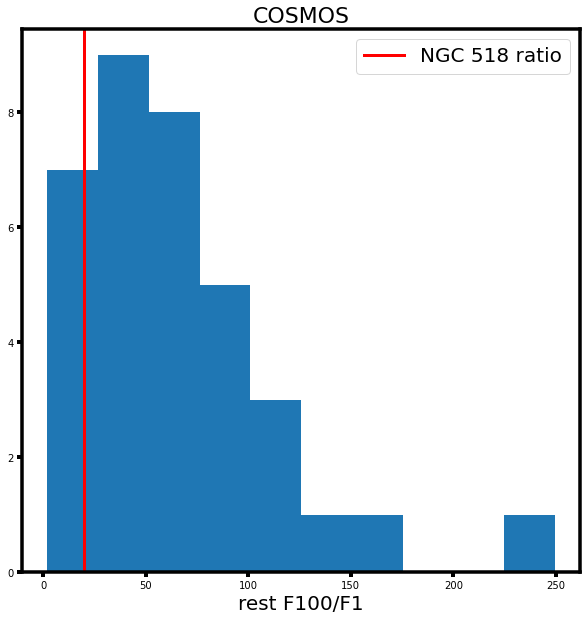

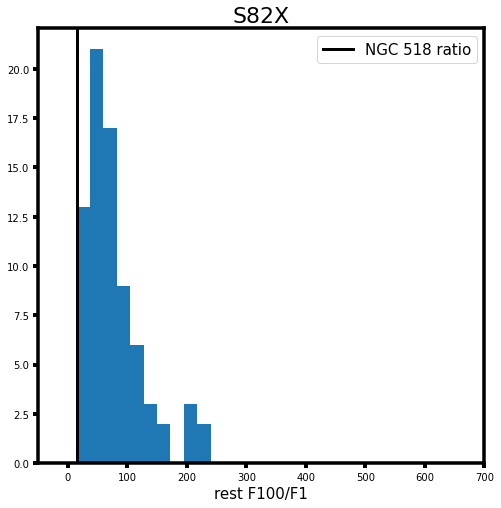

In [40]:
check = (F250_out < 0) & (field_out == 'COSMOS')

f250_check = F250_out[check][spec_z_out[check] >= 1.0]
f24_check = F24_out[check][spec_z_out[check] >= 1.0]
f4_check = F4_out[check][spec_z_out[check] >= 1.0]

cosmos_upper = 5310/3

plt.figure(figsize=(10,10),facecolor='white')
plt.title('COSMOS',fontsize=22)
plt.hist((cosmos_upper)/f4_check)
plt.axvline(x = 20, color='r',lw='3',label='NGC 518 ratio')
plt.xlabel('rest F100/F1',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/Users/connor_auge/Desktop/Flux_ratio.pdf')
plt.show()


check = (F250_out < 0) & (field_out == 'S82X')
# check = (field_out == 'S82X')

s82x_upper = 13000/3


f250_check = F250_out[check][spec_z_out[check] >= 1.0]
f24_check = F24_out[check][spec_z_out[check] >= 1.0]
f4_check = F4_out[check][spec_z_out[check] >= 1.0]


# print(f24_check)

plt.figure(figsize=(8,8),facecolor='white')
plt.title('S82X',fontsize=22)
plt.hist((s82x_upper)*3/f4_check)
plt.axvline(x = 15, color='k',lw='3',label='NGC 518 ratio')
plt.xlabel('rest F100/F1',fontsize=15)
plt.xlim(-50,700)
plt.legend(fontsize=15)
plt.show()



In [41]:
print(len(field_out[(field_out == 'S82X')&(spec_z_out >= 1.0)]))

print(f250_check/f24_check)

90
[-365.03897753 -219.9577352  -281.53943798 -260.32965289 -374.9205447
 -248.85091349 -274.87752977 -242.73882162 -384.23076923 -384.23076923
 -240.51337872 -335.07284977 -250.69128665 -384.23076923 -211.02759006
 -384.23076923 -428.09409694 -353.7848565  -270.03598326 -305.81757436
 -340.67419574 -284.40631763 -412.98971794 -385.816893   -133.82709147
 -339.16641374 -298.08439391 -233.95872143 -200.15739461 -273.61458224
 -327.74738805 -225.08120903 -445.38874615 -413.75117423 -254.88204286
 -503.43017063 -324.74258194 -209.80297361 -456.60350331 -385.12990216
 -262.74789133 -347.66393335 -367.73861774 -386.13506281 -358.37626531
 -245.12140615 -528.61470396 -305.30874168 -295.62396617 -240.95682905
 -348.61337015 -373.88603084 -482.54657707 -485.66772039 -384.23076923
 -403.21737624 -384.23076923 -306.15350746 -358.04634053 -269.36380568
 -345.41344589 -222.40228211 -438.96029526 -520.40233833 -247.90565825
 -230.48785133 -243.42548239 -359.03702719 -332.9195043  -262.02289416
 -34

In [42]:
print(F250_out[(field_out == 'S82X')&(spec_z_out >= 1.0)])

[  93919.7421875  -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.           50124.8359375  -999000.         -999000.
   78976.34375    -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
   49209.05078125 -999000.         -999000.         -999000.
 -999000.         -999000.         -999000.         -999000.
 -999000.         -99900

In [43]:
from astropy.table import Table

h = np.asarray(['ID','field','RA','Dec','spec_z','Lx',
                'F24','F24err','F250','F250err','F350','F350err',
                'F500','F500err'])

print(len(h))
print(len([ID_out,field_out,ra_out,dec_out,spec_z_out,Lx_out,
           F24_out,F24err_out,F250_out,F250err_out,F350_out,F350err_out,F500_out,F500err_out]))

t = Table([ID_out,field_out,ra_out,dec_out,spec_z_out,Lx_out,
           F24_out,F24err_out,F250_out,F250err_out,F350_out,F350err_out,F500_out,F500err_out],names=(h))


t.write('/Users/connor_auge/Research/Disertation/catalogs/Auge_AGN_stacking_info3.fits',format='fits',overwrite=True)

14
14


In [44]:
with fits.open('/Users/connor_auge/Research/Disertation/catalogs/Auge_AGN_stacking_info3.fits') as hdul:
    data = hdul[1].data
    cols = hdul[1].columns

In [45]:
cols

ColDefs(
    name = 'ID'; format = 'J'
    name = 'field'; format = '7A'
    name = 'RA'; format = 'D'
    name = 'Dec'; format = 'D'
    name = 'spec_z'; format = 'D'
    name = 'Lx'; format = 'D'
    name = 'F24'; format = 'D'
    name = 'F24err'; format = 'D'
    name = 'F250'; format = 'D'
    name = 'F250err'; format = 'D'
    name = 'F350'; format = 'D'
    name = 'F350err'; format = 'D'
    name = 'F500'; format = 'D'
    name = 'F500err'; format = 'D'
)

546


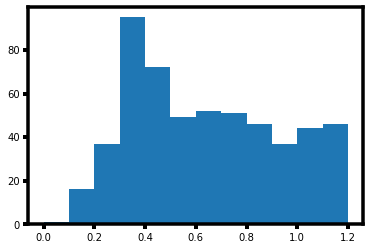

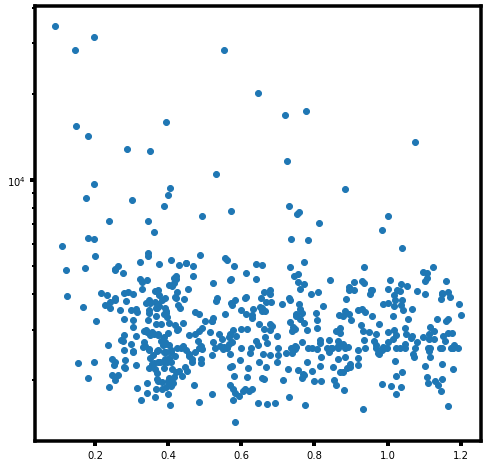

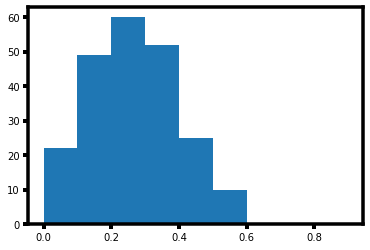

25
[ -99.  -99.  -99. ... -999. -999. -999.]


In [46]:
F24_in = data['F24']
ID_in = data['ID']
field = data['field']
z = data['spec_z']
f24 = data['F24']
f24err = data['F24err']

print(len(z[field == 'S82X']))

plt.hist(z[field == 'S82X'],bins=np.arange(0,1.3,0.1))
plt.show()

plt.figure(figsize=(8,8),facecolor='w')
plt.scatter(z[field == 'S82X'],f24[field == 'S82X'])
plt.yscale('log')
plt.show()

plt.hist(f24err[field == 'S82X']/f24[field == 'S82X'],bins=np.arange(0,1,0.1))
plt.show()

print(len(f24[f24 == 2600]))
print(f24)

# print(f24err[field == 'S82X']/f24[field == 'S82X'])

In [47]:
for i in range(len(data['field'])):
    print(data['field'][i],data['Lx'][i],data['F24'][i])

COSMOS 1.88297789344644e+44 -99.0
COSMOS 1.083536493338459e+45 -99.0
COSMOS 1.971721985848878e+44 -99.0
COSMOS 2.0176414930236647e+44 -99.0
COSMOS 2.317403606281887e+43 -99.0
COSMOS 1.1880766442285793e+44 -99.0
COSMOS 1.083536493338459e+45 -99.0
COSMOS 3.3484608174742685e+43 -99.0
COSMOS 3.9340956627980763e+43 -99.0
COSMOS 2.7217301783520528e+44 -99.0
COSMOS 1.4071823599378412e+43 -99.0
COSMOS 2.2638270123947794e+44 -99.0
COSMOS 7.849539029907067e+43 -99.0
COSMOS 1.569681013771732e+43 -99.0
COSMOS 1.840107032475612e+44 -99.0
COSMOS 1.6608861893913268e+43 -99.0
COSMOS 4.702086932314391e+43 -99.0
COSMOS 3.5481276592172913e+43 -99.0
COSMOS 1.4956946234970238e+44 -99.0
COSMOS 8.219485070915344e+43 -99.0
COSMOS 1.134603190945962e+43 -99.0
COSMOS 5.70090090300237e+43 -99.0
COSMOS 2.505539701110468e+43 -99.0
COSMOS 1.6026752363950485e+43 -99.0
COSMOS 2.785116654411893e+43 4528.89013671875
COSMOS 1.8749893696454512e+43 118.84400939941406
COSMOS 2.212304568443475e+43 -99.0
COSMOS 2.721730178352

S82X 5.13675e+44 4733.978148158851
S82X 2.14541e+44 2549.331128332582
S82X 7.647880743262846e+43 2295.230196361128
S82X 3.658290575670535e+43 2881.5505915188355
S82X 3.65877e+43 2764.5614572482887
S82X 4.39089e+44 2600.0
S82X 2.44516e+43 3729.290792471426
S82X 1.6960356122195508e+44 2333.5991015780974
S82X 1.0334599969171801e+44 3239.114117261453
S82X 1.3693e+44 3608.386496517572
S82X 4.76323e+43 4032.9816772413988
S82X 2.38776e+44 6209.711862688737
S82X 1.12982e+43 2366.4026822466103
S82X 1.26697e+44 2835.587471993772
S82X 4.62726e+44 1993.5459434825154
S82X 1.43681e+43 2977.187925128385
S82X 1.6541e+44 2379.1742396720265
S82X 2.3013e+44 2823.7500324086704
S82X 2.77466e+44 3699.5069617242416
S82X 1.74617e+44 2997.9628640480387
S82X 2.47295e+43 2321.600287700492
S82X 1.7697e+45 3266.6533376524417
S82X 2.93648e+43 5053.895397535477
S82X 2.52626e+44 2470.735463655534
S82X 4.16222e+44 2600.0
S82X 1.97465e+43 2649.880253743668
S82X 3.75381e+43 3388.646366193879
S82X 1.15585e+44 2932.420513

In [48]:
print(len(F24_in))
print(len(F24_in[np.isnan(F24_in)]))

1298
0


In [49]:
bad_24 = np.isnan(F24_in)

print(field[bad_24])
print(data['spec_z'][bad_24])



[]
[]


In [50]:
# s82x_ID_in = ID_in[field=='S82X']

# bad_s82x_ID_in = ID_in[bad_24]


# ix, iy = match(s82x_id,bad_s82x_ID_in)

# print(len(s82x_id[ix]))

# print(s82x_w4_flux[ix])

In [51]:
def Flux_to_Lum(F,z):
    '''Function to convert flux to luminosity'''
    cosmo = FlatLambdaCDM(H0=70, Om0=0.29, Tcmb0=2.725)
    dl = cosmo.luminosity_distance(z).value # Distance in Mpc
    dl_cgs = dl*(3.0856E24) # Distance from Mpc to cm

    # convert flux to luminosity 
    L = F*4*np.pi*dl_cgs**2
    return L

# Check FIR Stack

In [52]:
with fits.open('/Users/connor_auge/Research/Disertation/catalogs/Auge_AGN_stacking_info3.fits') as hdul:
    in_data = hdul[1].data
    in_cols = hdul[1].columns

In [53]:
in_cols

ColDefs(
    name = 'ID'; format = 'J'
    name = 'field'; format = '7A'
    name = 'RA'; format = 'D'
    name = 'Dec'; format = 'D'
    name = 'spec_z'; format = 'D'
    name = 'Lx'; format = 'D'
    name = 'F24'; format = 'D'
    name = 'F24err'; format = 'D'
    name = 'F250'; format = 'D'
    name = 'F250err'; format = 'D'
    name = 'F350'; format = 'D'
    name = 'F350err'; format = 'D'
    name = 'F500'; format = 'D'
    name = 'F500err'; format = 'D'
)

In [54]:
in_ID, in_field, in_Lx, in_z, in_24, in_250 = in_data['ID'], in_data['field'], in_data['Lx'], in_data['spec_z'], in_data['F24'], in_data['F250']
in_250err = in_data['F250err']
in_24 = in_data['F24']
in_24err = in_data['F24err']

In [55]:
print(len(in_ID))

1298


In [56]:
print(len(in_24[in_field == 'S82X'][in_24[in_field == 'S82X'] == 2600]))

25


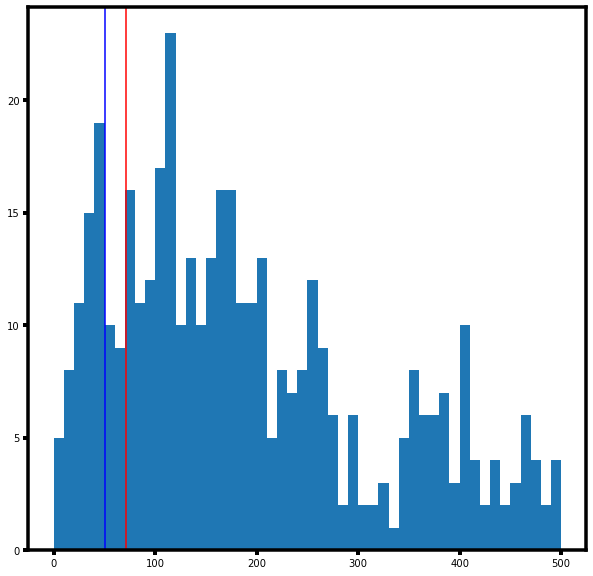

In [57]:
# Check cosmos 24
cosmos_24 = in_24[in_field == 'COSMOS']
plt.figure(figsize=(10,10),facecolor='w')
plt.hist(cosmos_24,np.arange(-0.1,500,10))
plt.axvline(71,color='r')
plt.axvline(10*5,color='b')
plt.show()

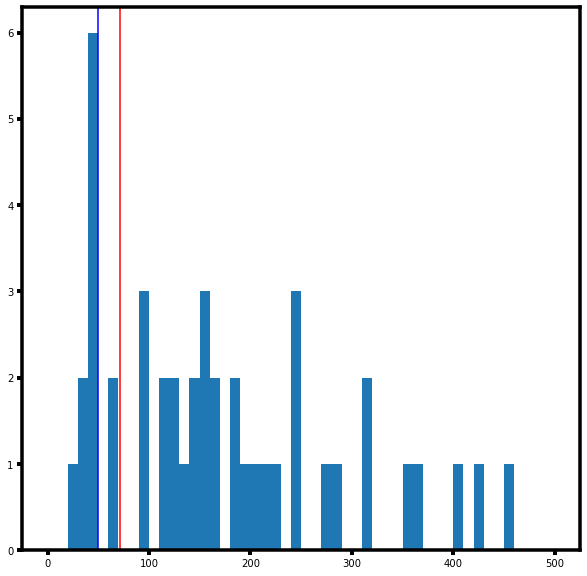

In [58]:
goodss_24 = in_24[in_field == 'GOODS-S']
plt.figure(figsize=(10,10),facecolor='w')
plt.hist(goodss_24,np.arange(-0.1,500,10))
plt.axvline(71,color='r')
plt.axvline(10*5,color='b')
plt.show()

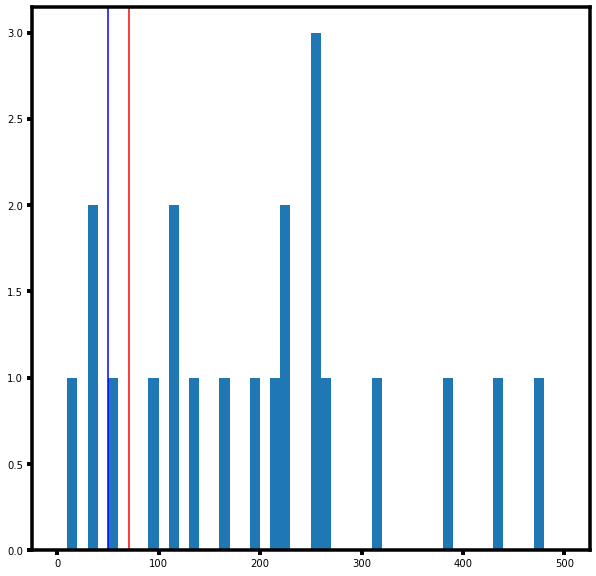

In [59]:
goodsn_24 = in_24[in_field == 'GOODS-N']
plt.figure(figsize=(10,10),facecolor='w')
plt.hist(goodsn_24,np.arange(-0.1,500,10))
plt.axvline(71,color='r')
plt.axvline(10*5,color='b')
plt.show()

In [107]:
s82x_ID = in_ID[in_field == 'S82X']
s82x_field = in_field[in_field == 'S82X']
s82x_Lx = in_Lx[in_field == 'S82X']
s82x_z = in_z[in_field == 'S82X']
s82x_24 = in_24[in_field == 'S82X']
s82x_24err = in_24err[in_field == 'S82X']
s82x_250 = in_250[in_field == 'S82X']
s82x_250err = in_250err[in_field == 'S82X']

print(len(s82x_24))
print(len(s82x_24[s82x_24 == 2600]))
print(len(s82x_24[s82x_24 <= 0]))
print(len(s82x_24[np.isnan(s82x_24)]))

s82x_24[s82x_24 == 2600] = np.nan
s82x_Fnu_24 = s82x_24*1E-29

stack_F250_jy = np.asarray([10.59,9.31,8.38,8.10,7.18,13.93])*1000
stack_z = np.asarray([0.27,0.37,0.54,0.61,0.90,1.00])
stack_Fnu = stack_F250_jy*1E-29

546
25
0
0


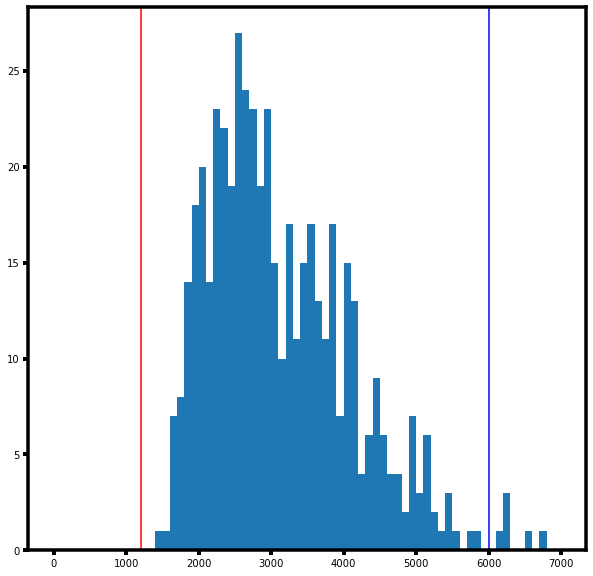

546


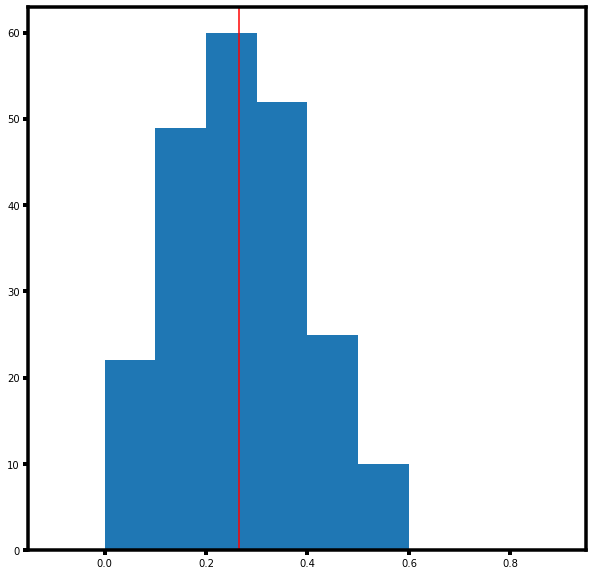

In [108]:
# Check S82X 22 upper limit

plt.figure(figsize=(10,10),facecolor='w')
plt.hist(s82x_24,np.arange(-0.1,7000,100))
plt.axvline(1200,color='r')
plt.axvline(6000,color='b')
# plt.axvline(10,color='b')
plt.show()

print(len(s82x_24))

plt.figure(figsize=(10,10),facecolor='w')
plt.hist(s82x_24err/s82x_24,np.arange(-0.1,1.0,0.1))
plt.axvline(np.nanmedian(s82x_24err/s82x_24),color='r')
plt.show()

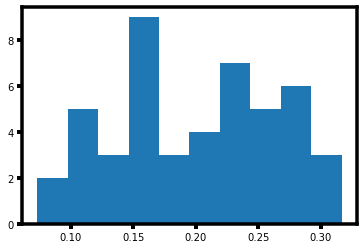

In [109]:
plt.figure(facecolor='w')
plt.hist(s82x_250err[s82x_250 >0]/s82x_250[s82x_250 >0])
plt.show()

In [110]:
c = const.c.to('cm/s').value #speed of light in cgs

s82x_24_cgs = 24*1E-4 # observed wavelength from microns to cm
s82x_24_cgs_rest = 24/(1+s82x_z)*1E-4
s82x_24_freq1 = c/s82x_24_cgs # convert obs wavelength to a frequency
s82x_24_freq2 = c/s82x_24_cgs_rest # convert obs wavelength to a frequency

s82x_250_cgs = 250*1E-4 # observed wavelength from microns to cm
s82x_250_cgs_rest = 250/(1+s82x_z)*1E-4
s82x_250_freq1 = c/s82x_250_cgs # convert obs wavelength to a frequency
s82x_250_freq2 = c/s82x_250_cgs_rest # convert obs wavelength to a frequency

s82x_Flambda_24 = s82x_Fnu_24*(c/s82x_24_cgs**2)

nuFnu_24_1 = s82x_Fnu_24*s82x_24_freq1
nuFnu_24_2 = s82x_Fnu_24*s82x_24_freq2
lambdaFlambda_24 = s82x_24_cgs*s82x_Flambda_24
stack_nuFnu = stack_Fnu*s82x_250_freq1


L24_1 = Flux_to_Lum(nuFnu_24_1,s82x_z)
# L24_2 = Flux_to_Lum(lambdaFlambda_24,s82x_z)
L24_2 = Flux_to_Lum(nuFnu_24_2,s82x_z)
stack_L250 = Flux_to_Lum(stack_nuFnu,stack_z)

L24 = L24_1/(1+s82x_z)

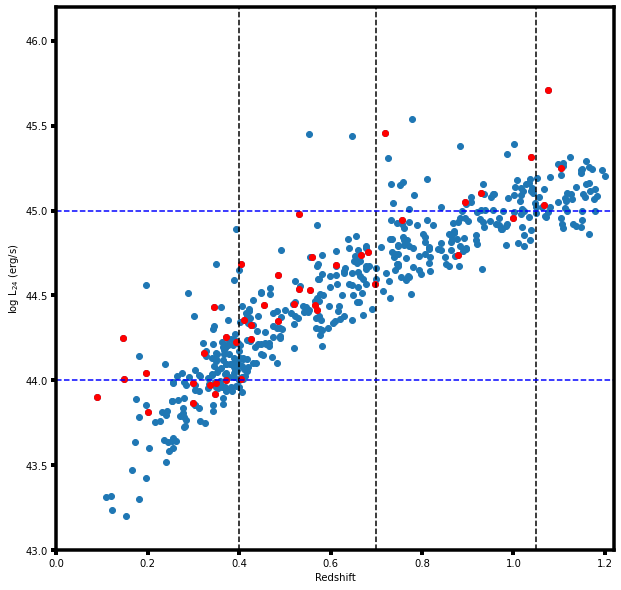

In [111]:
# plt.figure(figsize=(6,6),facecolor='white')
# plt.plot(s82x_z,np.log10(L24_1),'o',label='1')
# plt.plot(s82x_z,np.log10(L24_2),'.',label='2')
# # plt.plot(s82x_z[s82x_250 > 0],np.log10(L24_1[s82x_250 > 0]),'.',color='r')
# plt.axvline(0.45,ls='--',color='k')
# plt.axvline(0.70,ls='--',color='k')
# plt.xlabel('Redshift')
# plt.ylabel(r'log L$_{24}$ (erg/s)')
# plt.legend()
# plt.show()

off = 0.0

plt.figure(figsize=(10,10),facecolor='white')
plt.plot(s82x_z,np.log10(L24)-off,'o')
plt.plot(s82x_z[s82x_250 > 0],np.log10(L24[s82x_250 > 0])-off,'o',color='r')
plt.axvline(0.4,ls='--',color='k')
plt.axvline(0.70,ls='--',color='k')
plt.axvline(1.05,ls='--',color='k')
plt.axhline(44,ls='--',color='b')
plt.axhline(47,ls='--',color='b')
plt.axhline(45.,ls='--',color='b')
plt.xlabel('Redshift')
plt.ylabel(r'log L$_{24}$ (erg/s)')
plt.xlim(0,1.22)
plt.ylim(43,46.2)
plt.show()

In [113]:
bin_check1 = (s82x_250 <= 0) & (s82x_z <= 0.4) & (np.log10(L24) <= 44)
bin_check2 = (s82x_250 <= 0) & (s82x_z <= 0.4) & (np.logical_and(np.log10(L24) <= 47.0,np.log10(L24) > 44.))
bin_check3 = (s82x_250 <= 0) & (np.logical_and(s82x_z > 0.4,s82x_z <= 0.7)) & (np.log10(L24) <= 44.5)
bin_check4 = (s82x_250 <= 0) & (np.logical_and(s82x_z > 0.4,s82x_z <= 0.7)) & (np.logical_and(np.log10(L24) <= 47.0,np.log10(L24) > 44.5))
bin_check5 = (s82x_250 <= 0) & (np.logical_and(s82x_z > 0.7,s82x_z <= 1.05)) & (np.log10(L24) <= 45)
bin_check6 = (s82x_250 <= 0) & (np.logical_and(s82x_z > 0.7,s82x_z <= 1.05)) & (np.logical_and(np.log10(L24) <= 47.0,np.log10(L24) > 45))
bin_check7 = (s82x_250 <= 0) & (np.logical_and(s82x_z > 1.05,s82x_z <= 1.25)) & (np.log10(L24) <= 47.0)
bin_check8 = (s82x_250 <= 0) & (np.isnan(L24))
print('Bin 1: ',len(s82x_Lx[bin_check1]),np.mean(s82x_z[bin_check1]),np.mean(np.log10(s82x_Lx[bin_check1])),np.log10(stack_L250[0]))
print('Bin 2: ',len(s82x_Lx[bin_check2]),np.mean(s82x_z[bin_check2]),np.mean(np.log10(s82x_Lx[bin_check2])),np.log10(stack_L250[1]))
print('Bin 3: ',len(s82x_Lx[bin_check3]),np.mean(s82x_z[bin_check3]),np.mean(np.log10(s82x_Lx[bin_check3])),np.log10(stack_L250[2]))
print('Bin 4: ',len(s82x_Lx[bin_check4]),np.mean(s82x_z[bin_check4]),np.mean(np.log10(s82x_Lx[bin_check4])),np.log10(stack_L250[3]))
print('Bin 5: ',len(s82x_Lx[bin_check5]),np.mean(s82x_z[bin_check5]),np.mean(np.log10(s82x_Lx[bin_check5])),np.log10(stack_L250[4]))
print('Bin 6: ',len(s82x_Lx[bin_check6]),np.mean(s82x_z[bin_check6]),np.mean(np.log10(s82x_Lx[bin_check6])),np.log10(stack_L250[5]))
print('Bin 7: ',len(s82x_Lx[bin_check7]),np.mean(s82x_z[bin_check7]),np.mean(np.log10(s82x_Lx[bin_check7])),np.log10(stack_L250[5]))
print('Bin 8: ',len(s82x_Lx[bin_check8]),np.mean(s82x_z[bin_check8]),np.mean(np.log10(s82x_Lx[bin_check8])),np.log10(stack_L250[5]))
print('Bins total: ',len(s82x_Lx[bin_check1])+len(s82x_Lx[bin_check2])+len(s82x_Lx[bin_check3])+
     len(s82x_Lx[bin_check4])+len(s82x_Lx[bin_check5])+len(s82x_Lx[bin_check6])+len(s82x_Lx[bin_check7]))
print('Total sources: ',len(s82x_Lx))


Bin 1:  66 0.27541146020997653 43.47412609867436 43.46043597545722
Bin 2:  68 0.352885935236426 43.580911173874625 43.72209864597313
Bin 3:  93 0.49320965108051096 43.78935639365571 44.068085956069105
Bin 4:  55 0.6134964569048448 44.10785441525121 44.18181740545412
Bin 5:  105 0.8518951398985727 44.2602102747804 44.544715521699324
Bin 6:  41 0.9323613832636577 44.494299240074845 44.94593433324363
Bin 7:  49 1.1278078653374497 44.47001431342253 44.94593433324363
Bin 8:  22 0.909734698859128 44.1908225703741 44.94593433324363
Bins total:  477
Total sources:  546


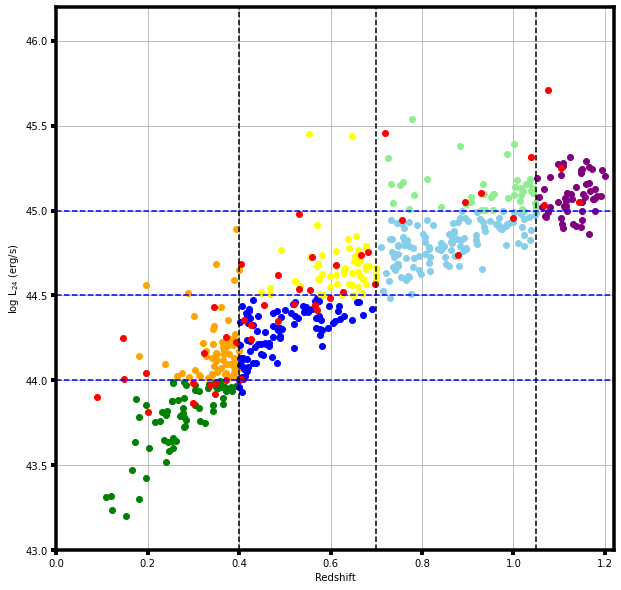

In [100]:
plt.figure(figsize=(10,10),facecolor='white')
plt.plot(s82x_z[bin_check1],np.log10(L24[bin_check1]),'o',c='green')
plt.plot(s82x_z[bin_check2],np.log10(L24[bin_check2]),'o',c='orange')
plt.plot(s82x_z[bin_check3],np.log10(L24[bin_check3]),'o',c='blue')
plt.plot(s82x_z[bin_check4],np.log10(L24[bin_check4]),'o',c='yellow')
plt.plot(s82x_z[bin_check5],np.log10(L24[bin_check5]),'o',c='skyblue')
plt.plot(s82x_z[bin_check6],np.log10(L24[bin_check6]),'o',c='lightgreen')
plt.plot(s82x_z[bin_check7],np.log10(L24[bin_check7]),'o',c='purple')
plt.plot(s82x_z[s82x_250 > 0],np.log10(L24[s82x_250 > 0])-off,'o',color='r')
plt.axvline(0.4,ls='--',color='k')
plt.axvline(0.70,ls='--',color='k')
plt.axvline(1.05,ls='--',color='k')
plt.axhline(44.,ls='--',color='b')
plt.axhline(44.5,ls='--',color='b')
plt.axhline(45,ls='--',color='b')
plt.xlabel('Redshift')
plt.ylabel(r'log L$_{24}$ (erg/s)')
plt.xlim(0,1.22)
plt.ylim(43,46.2)
plt.grid()
plt.show()

In [115]:
print(s82x_ID[bin_check1])
print(s82x_ID[bin_check2])
print(s82x_ID[bin_check3])
print(s82x_ID[bin_check4])
print(s82x_ID[bin_check5])
print(s82x_ID[bin_check6])
print(s82x_ID[bin_check7])
print(s82x_ID[bin_check8])


print(len(s82x_ID[bin_check1])+len(s82x_ID[bin_check2])+len(s82x_ID[bin_check3])+len(s82x_ID[bin_check4])+len(s82x_ID[bin_check5])+len(s82x_ID[bin_check6])+len(s82x_ID[bin_check7])+len(s82x_ID[bin_check8]))


bin1 = np.ones(np.shape(s82x_ID[bin_check1]))
bin2 = np.ones(np.shape(s82x_ID[bin_check2]))+1
bin3 = np.ones(np.shape(s82x_ID[bin_check3]))+2
bin4 = np.ones(np.shape(s82x_ID[bin_check4]))+3
bin5 = np.ones(np.shape(s82x_ID[bin_check5]))+4
bin6 = np.ones(np.shape(s82x_ID[bin_check6]))+5

bin_number = np.append(bin1,bin2)
bin_number = np.append(bin_number,bin3)
bin_number = np.append(bin_number,bin4)
bin_number = np.append(bin_number,bin5)
bin_number = np.append(bin_number,bin6)

print(bin_number)


[  2387   2667   2700   2731   2803   2832   2846   2850   2868   2873
   2960   3015   3029   3092   3131   3171   3318   3335   3388   3398
   3485   3504   3739   3783   3840   3851   3854   3936   3939   3976
   4007   4034   4053   4214   4222   4276   4290   4295   4334   4387
   4409   4414   4592   4596   4602   4739   4747   4898   4964   5028
   5062   5089   5135   5143   5151   5172    417    434    492    514
    520    521  57494  89316 129876 129885]
[  2360   2463   2471   2525   2563   2598   2635   2693   2728   2782
   2811   2831   2840   2906   3053   3241   3246   3259   3264   3327
   3427   3488   3540   3547   3626   3628   3647   3708   3763   3810
   3831   3846   3861   3872   3884   3909   3966   3979   3982   4010
   4028   4031   4051   4073   4087   4139   4159   4264   4272   4407
   4418   4422   4424   4437   4456   4512   4696   4758   4791   4838
   4867   5031   5087    405    425  57498 129884 129887]
[  2363   2388   2420   2442   2446   2482   2

In [68]:
# X Need to turn 24 micron flux to luminosity to match bins given by allison
# X check number in each bin 
# X determine average Lx for each bin
# plot each bin on FIR plots (with lower limit line from NGC518?)
# Use stack to re-estimate the FIR interpolation for all S82X sources in each bin 
    # Use this value to remake FIR plots (with lower limit line from NGC518?)
# Send both versions to everyone to get thoughts. 

In [69]:
    def stack_check(z,F250,L22):
#         F250 = flux_jy[filter_name == 'Flux_250_s82x']
#         L22 = Lum_filter('W4')

        print(F250,z,np.log10(L22))
        
        bin1 = (F250 <= 0) & (z <= 0.45) & (np.log10(L22) <= 44.1)
        bin2 = (F250 <= 0) & (z <= 0.45) & (np.logical_and(np.log10(L22) <= 47.0, np.log10(L22 > 44.1)))
        bin3 = (F250 <= 0) & (np.logical_and(z > 0.45, z <= 0.7)) & (np.log10(L22) <= 44.7)
        bin4 = (F250 <= 0) & (np.logical_and(z > 0.45, z <= 0.7)) & (np.logical_and(np.log10(L22) <= 47.0, np.log10(L22) > 44.7))
        bin5 = (F250 <= 0) & (np.logical_and(z > 0.7, z >= 1.25)) & (np.log10(L22) <= 45.3)
        bin6 = (F250 <= 0) & (np.logical_and(z > 0.7, z >= 1.25)) & (np.logical_and(np.log10(L22) <= 47.0, np.log10(L22) > 45.3))
        
        bin_out = np.asarray([bin1,bin2,bin3,bin4,bin5,bin6])
        
        print(bin_out)
        print(np.where(bin_out)[0][0])

In [70]:
stack_check(0.5,-100,1E45)

-100 0.5 45.0
[False False False  True False False]
3


In [71]:
IDs = np.asarray([145252])

cosmos_nh[cosmos_id == IDs]

NameError: name 'cosmos_nh' is not defined

In [ ]:
a = np.array([1,2,3,4,5])
a[-3]

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from mag_flux import mag_to_flux

c = SkyCoord(ra = 28*u.degree, dec = 0.0*u.degree)
c.transform_to('galactic')

print(mag_to_flux(17.6,'W4')*1E3)
print(mag_to_flux(17.6,'W4',AB=False)*1E3)

In [ ]:
a = np.asarray(['a','b','c','d','e','f','g','h'])
b = np.asarray([1,2,3,4,5,6,7,8])
# b = np.asarray([1,2,np.nan,4,5,6,7,8])
# b = np.asarray([1,2,np.nan,np.nan,np.nan,np.nan,7,8])

c = 'd'

ind = np.where(a == c)[0]
ind_use = np.array([ind-1,ind,ind+1])
check = []
for i in range(len(ind_use)):
    print(b[ind_use[i]])
    check.append(b[ind_use[i][0]])
check = np.asarray(check)
if any(~np.isnan(check)):
    print('good')
else:
    print('bad')

In [ ]:
with fits.open('/Users/connor_auge/Research/Disertation/catalogs/Auge_AGN_stacking_info3.fits') as hdul:
    in_data = hdul[1].data
    in_cols = hdul[1].columns
    
    
new_ID, new_field, new_Lx, new_z, new_24, new_250 = in_data['ID'], in_data['field'], in_data['Lx'], in_data['spec_z'], in_data['F24'], in_data['F250']
new_250err = in_data['F250err']
new_24 = in_data['F24']
new_24err = in_data['F24err']


with fits.open('/Users/connor_auge/Research/Disertation/catalogs/Auge_AGN_stacking_info.fits') as hdul:
    in_data = hdul[1].data
    in_cols = hdul[1].columns
    
    
old_ID, old_field, old_Lx, old_z, old_24, old_250 = in_data['ID'], in_data['field'], in_data['Lx'], in_data['spec_z'], in_data['F24'], in_data['F250']
old_250err = in_data['F250err']
old_24 = in_data['F24']
old_24err = in_data['F24err']

In [ ]:
check = []
for i in range(len(new_ID[new_field == 'S82X'])):
    ind = np.where(old_ID[old_field == 'S82X'] == new_ID[new_field == 'S82X'][i])[0]
    if len(ind > 0):
        check.append(1)
#         print('1: ',new_24[new_field == 'S82X'][i])
        new_24[new_field == 'S82X'][i] = old_24[old_field == 'S82X'][ind]
#         print('2: ',new_24[new_field == 'S82X'][i])
    else:
        continue
        
print(len(new_24[new_field == 'S82X']),len(old_ID[old_field == 'S82X']))
print(len(new_24[new_24 == 2600]))
print(len(check))

In [ ]:
for i in old_ID:
    print(i)

In [ ]:
print(len(old_ID[old_field == 'S82X']))
print(len(set(old_ID[old_field == 'S82X'])))